In [1]:
# DCL CNN

# importing all needed functions
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import glob
import time
from Tools import tools
import traceback
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import jit
import os
import shutil
import line_profiler
from scipy import stats
from line_profiler import profile
%load_ext line_profiler
import pwkit.bblocks
import sys
import pandas as pd

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")


In [2]:
# reading the ttsplit file
df = pd.read_csv('ttsplit')

# getting the test and train events
test_events = df[df['category'] == 'test']['filename'].tolist()
print(test_events[:10])  

train_events = df[df['category'] == 'train']['filename'].tolist()
print(train_events[:10])  

['TGF_bn190821888', 'SFLARE_bn220520007', 'GRB_bn100224112', 'TGF_bn151209879', 'SGR_bn220114673', 'SFLARE_bn110309971', 'TGF_bn100331421', 'TGF_bn150209374', 'SFLARE_bn130421669', 'SGR_bn160623809']
['SFLARE_bn140204646', 'SFLARE_bn240208118', 'SFLARE_bn240204601', 'TGF_bn221114697', 'SGR_bn211226538', 'TGF_bn100901124', 'GRB_bn150403913', 'TGF_bn170911550', 'TGF_bn101012231', 'SGR_bn160623838']


In [3]:
zero_files = 0

In [4]:
def delete_folders(directory, folder_list):
    for folder in folder_list:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            try:
                shutil.rmtree(folder_path)
                print(f"Deleted folder: {folder}")
            except Exception as e:
                print(f"Error deleting folder {folder}: {str(e)}")
        else:
            print(f"{folder} is not a folder or does not exist.")

@jit(nopython=True)
def filter_counts(times, channels, min_ch, max_ch, trigtime):
    """
    Filter count data based on channel range and subtract trigtime.
    
    :param times: Array of event times
    :param channels: Array of channel numbers
    :param min_ch: Minimum channel number
    :param max_ch: Maximum channel number
    :param trigtime: Trigger time to be subtracted
    :return: Filtered and adjusted count data
    """
    counts = []
    for t, ch in zip(times, channels):
        if min_ch <= ch <= max_ch:
            counts.append(t - trigtime)
    return np.array(counts)

@profile
def process_folder(folder, bin_list,data_no,r,chr1,chr2,data_set_path,source_data_set_path,error_folders,zero_files = zero_files, plot = False):
    """
    Process a single folder of data.
    
    :param folder: Name of the folder to process
    :param bin_list: List of bin sizes to use
    """
    try:
        # Extract event information from folder name
        event_type, event = folder.split("_")

        mod_folder = folder[:-1] if folder [-1] == 'd' else folder


        # check if the file is processed
        data_file_path = Path(data_set_path) / f"{event_type}_{event}"
        if data_file_path.exists():
            # print(f"File already processed: {data_file_path}")
            return

        # Construct file pattern and find matching files
        file_pattern = str(Path(source_data_set_path) / mod_folder / 'current' / '*_tte_*')
        NaI_detector = glob.glob(file_pattern)


        # Read data from FITS file
        with fits.open(NaI_detector[0], memmap=True) as hdul:
            all_count_data = hdul[2].data
            trigtime = float(hdul[2].header['TRIGTIME'])

        # Extract times and channels from all_count_data
        times = all_count_data['TIME'].astype(float)
        channels = all_count_data['PHA'].astype(int)

        # Filter counts for different channel ranges
        counts_1 = filter_counts(times, channels, chr1[0], chr1[1], trigtime)
        counts_2 = filter_counts(times, channels, chr2[0], chr2[1], trigtime)

        data_array = []
        
        # Process both count ranges
        for i in bin_list:
            sep_sig = []
            ch_no = 1
            for counts in [counts_1,counts_2]:
                # Calculate range and bin size
                range_min = -data_no * i * r
                range_max = data_no * i * (1-r)
                bin_size = i

                # print(range_max)
                # print(range_min)
    
                # Create histogram
                bin_edges = np.arange(range_min, range_max, bin_size)
                hist, edges = np.histogram(counts, bins=bin_edges)
                hist = adjust_zeros(hist)
                bin_widths = edges[1:]-edges[:-1]
                hrates = hist / bin_size

                # Perform Bayesian Block Analysis
                bayes = pwkit.bblocks.bin_bblock(widths = bin_widths, counts = hist, p0 = 0.01)

                # Getting the results of the analysis
                block_starts = (bayes.get('blockstarts') * i) + range_min
                block_stops = block_starts + bayes.get('widths')
                bins = np.array(list(block_starts) + list([block_stops[-1]]))
                rates = bayes.get('rates')

                # Find indices where rates are non-zero
                non_zero_indices = np.nonzero(rates)[0]
                
                # Select rates that are non-zero
                rates = rates[non_zero_indices]
                
                # Select corresponding bins
                bins = np.concatenate([bins[non_zero_indices], [bins[non_zero_indices[-1] + 1]]])

                sigw = bins[-2] - bins[1]

                bk2 = bins[1] - (5 * bin_size)
                bk3 = bins[-2] + (5 * bin_size)
                bk1 = bk2 - sigw - (50 * bin_size) if (bk2 - sigw - (50 * bin_size)) > bins[0] else bins[0]
                bk4 = bk3 + sigw + (50 * bin_size) if (bk3 + sigw + (50 * bin_size)) < bins[-1] else bins[-1]

                # bk2 = bins[1]  # 
                # bk3 = bins[-2] # 
                # bk1 = bins[0]  # 
                # bk4 = bins[-1] # 
                
                bkgd = [(bk1,bk2),(bk3,bk4)]

                # Check if background is proper
                bkgd_check = bk1<bk2<bk3<bk4

                # Checking for signal
                # Checks False alarm probability p0, number of bins, and if background is detected around trigger
                if bayes.get('finalp0') >= 0.05 or len(bins)<4 or not(bk2 - 5 <= 0 <= bk3 + 5) or not bkgd_check:
                    if plot:
                        print('no signal')
                        plt.stairs(hrates, edges)
                        plt.show()
                        plt.stairs(rates, bins)
                        plt.show()
                    # print('no signal')
                    # print(i,ch_no)
                    signal = np.zeros(data_no-1).astype(np.int32) # send no signal
                                    
                else:
                    y = hrates
                    x = (edges[1:] + edges[:-1]) / 2
                    bkgd_pol,_ = best_fit_polynomial(x, y, bkgd)

                    # Create mask for y between bk2 and bk3
                    mask = (x >= bk2) & (x <= bk3)

                    # Apply the mask and take the maximum of 0 and y - bkgd_pol(x)
                    signal = np.zeros(data_no-1).astype(np.int32)
                    signal[mask] = np.maximum(0, (y[mask] - bkgd_pol(x[mask]))).astype(np.int32)
                    
                    if plot:
                        # Plot the results
                        plt.stairs(hrates,edges)
                        plt.xlabel('Time (s)')
                        plt.ylabel('rates')
                        plt.title(f'light curve ; ch = {ch_no} ;bin size = {bin_size}s')
                        # Plot each shaded area
                        for i, (x1, x2) in enumerate(bkgd):
                            plt.axvspan(x1, x2, alpha=0.3, color='red',label = 'background selection') 
                        # make sure most things are visible
                        if min(edges) < counts.min():
                            plt.gca().set_xlim(left=counts.min())
                        if max(edges) > counts.max():
                            plt.gca().set_xlim(right=counts.max())
                        plt.axvline(x=0, color='red', linestyle='--', linewidth=0.5)
                        # Evaluate the background polynomial for plotting
                        bkgd_y = bkgd_pol(x)
                        
                        # Check if the background blows up
                        if np.any(np.abs(bkgd_y) > 10 * np.max(np.abs(y))) or np.any(np.abs(bkgd_y) < 0.1 * np.min(np.abs(y[y != 0]))):                
                            # Plot the background within the limits
                            mask = (bkgd_y >= plt.ylim()[0]) & (bkgd_y <= plt.ylim()[1])
                            plt.plot(x[mask], bkgd_y[mask], '--', label='background')
                        else:
                            # If it doesn't blow up, plot normally
                            plt.plot(x, bkgd_y, '--', label='background')
                        plt.show()

                        # signal plot
                        plt.title(f'light curve ; ch = {ch_no} ;bin size = {bin_size}s')
                        plt.axvline(x=0, color='red', linestyle='--', linewidth=0.5)
                        plt.xlabel('Time (s)')
                        plt.ylabel('rates')
                        plt.plot(x,signal)
                        plt.show()

                # updatae channel number and save signal
                ch_no = ch_no + 1               
                sep_sig.extend(signal)
                

            # Accumulate histogram data
            data_array.extend(sep_sig)

        # Convert accumulated data to numpy array
        data_array = np.array(data_array)

        if data_array.shape[0] != len(bin_list) * 2 * (data_no-1):
            print('something may have gone wrong in ', folder)
            print(data_array.shape, len(bin_list) * 2 * (data_no-1))
        
        if plot:
            print('shape', data_array.shape)

        if np.all(data_array == 0):
            zero_files = zero_files + 1
            
        # Save data to file
        with open(data_file_path, 'w') as f:
            np.savetxt(f, data_array, fmt='%d', delimiter='')
            # print(f"Data saved to {data_file_path}")

    except Exception as e:
        # Handle and log any errors
        print(f'error {e} in {folder}')
        # traceback.print_exc()
        error_folders.append(folder)     

    return zero_files   

def adjust_zeros(arr):
    # Create a copy of the input array
    result = np.copy(arr)
    
    # Find first non-zero element
    first_non_zero = np.argmax(arr != 0)
    
    # Find last non-zero element
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0) - 1
    
    # Replace value after leading zeros with zero if there are leading zeros
    if first_non_zero > 0:
        result[first_non_zero] = 0
    
    # Replace value before trailing zeros with zero if there are trailing zeros
    if last_non_zero < len(arr) - 1:
        result[last_non_zero] = 0
    
    return result

def best_fit_polynomial(x, y, background_intervals):
    # Filter data to include only background intervals
    mask = np.zeros(len(x), dtype=bool)
    for start, end in background_intervals:
        mask |= (x >= start) & (x <= end)
    
    x_bg = x[mask]
    y_bg = y[mask]
    
    best_order = 0
    best_polynomial = None
    best_r_squared = -np.inf
    
    for order in range(1, 5):  # Test polynomials of order 1 to 4
        coeffs = np.polyfit(x_bg, y_bg, order)
        p = np.poly1d(coeffs)
        
        # Calculate R-squared
        y_pred = p(x_bg)
        r_squared = 1 - np.sum((y_bg - y_pred)**2) / np.sum((y_bg - np.mean(y_bg))**2)
        
        # Perform F-test to compare with lower order model
        if order > 1:
            f_statistic = ((r_squared - prev_r_squared) / (order - prev_order)) / \
                          ((1 - r_squared) / (len(x_bg) - order - 1))
            p_value = 1 - stats.f.cdf(f_statistic, 1, len(x_bg) - order - 1)
            
            if p_value < 0.05 and r_squared > best_r_squared:
                best_order = order
                best_polynomial = p
                best_r_squared = r_squared
        else:
            best_order = order
            best_polynomial = p
            best_r_squared = r_squared
        
        prev_order = order
        prev_r_squared = r_squared
    
    return best_polynomial, best_order

def full_plot(x,y,bkgd,bkgd_pol,peak = 0,peak_time = 0):
        # Create the plot
        plt.figure(figsize=(12, 5))
        plt.plot(x,y,label = 'data')

        # Plot each shaded area
        for i, (x1, x2) in enumerate(bkgd):
            plt.axvspan(x1, x2, alpha=0.3, color='red',label = 'background selection') 
        
        check_poly = np.poly1d([0,1])
        if not np.all(bkgd_pol.coef == check_poly.coef):
            # Evaluate the background polynomial
            bkgd_y = bkgd_pol(x)
            
            # Check if the background blows up
            if np.any(np.abs(bkgd_y) > 10 * np.max(np.abs(y))) or np.any(np.abs(bkgd_y) < 0.1 * np.min(np.abs(y[y != 0]))):                
                # Plot the background within the limits
                mask = (bkgd_y >= plt.ylim()[0]) & (bkgd_y <= plt.ylim()[1])
                plt.plot(x[mask], bkgd_y[mask], '--', label='background')
            else:
                # If it doesn't blow up, plot normally
                plt.plot(x, bkgd_y, '--', label='background')
        
        # If it blows up, limit the y-axis
        y_min, y_max = np.min(y), np.max(y)
        y_range = y_max - y_min
        plt.ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        plt.axvline(x=0,ls='--' ,alpha = 0.5, linewidth=1)

        if peak == 0 and peak_time == 0:
            pass
        else:
            plt.scatter(peak_time,peak, s=40, c='k', marker='*', label='peak')

        plt.legend()
        plt.show()



Folder 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds8' created successfully.
Folder 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds8\test' created successfully.
Folder 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds8\train' created successfully.
Folder 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds8\other' created successfully.
start
total :  4374
Data has been written to C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds8\params.json
saving processed events to  C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds8\test


Processing folders:   0%|          | 0/5 [00:00<?, ?folder/s]

no signal


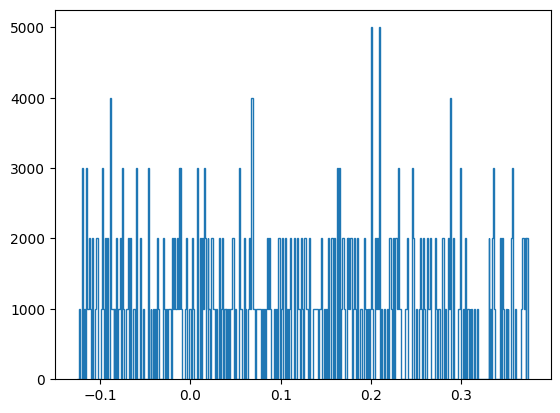

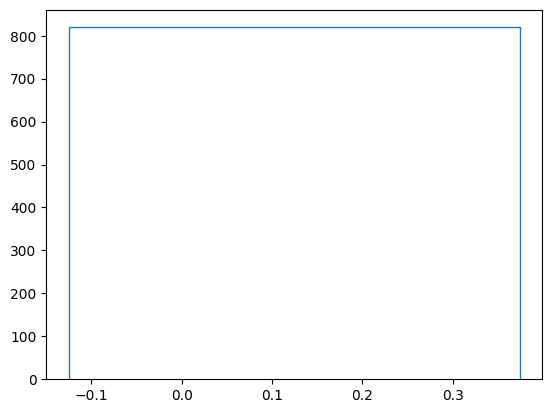

no signal


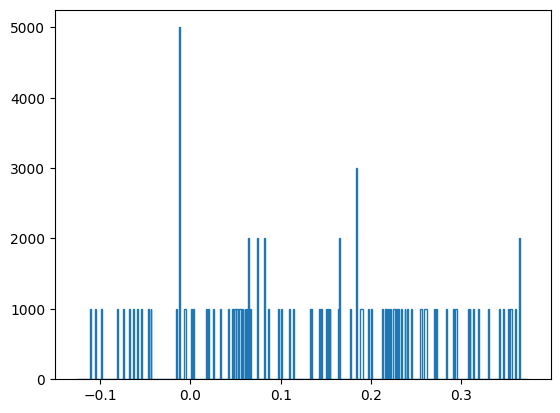

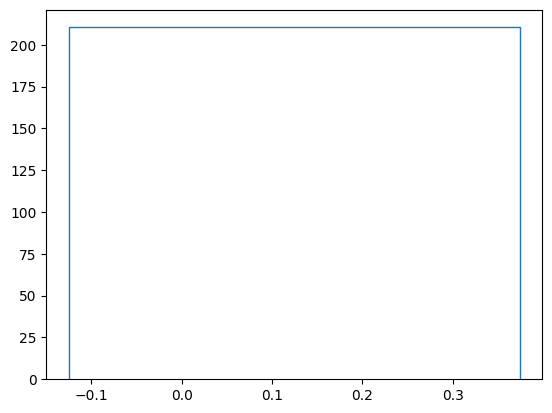

no signal


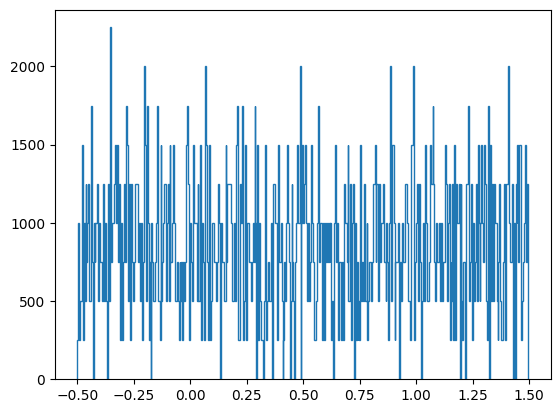

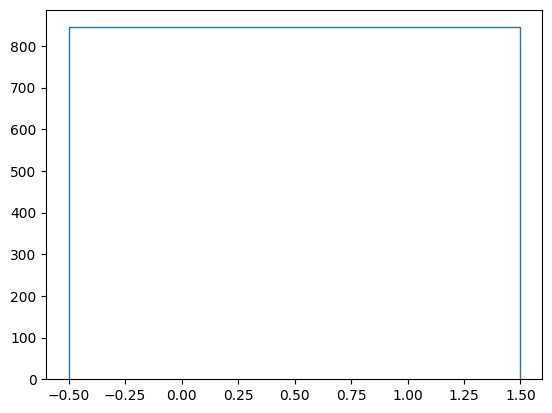

no signal


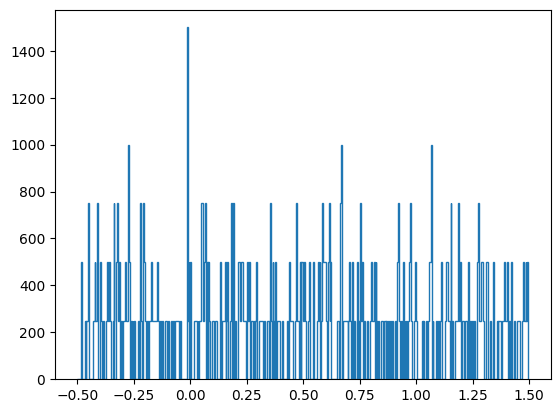

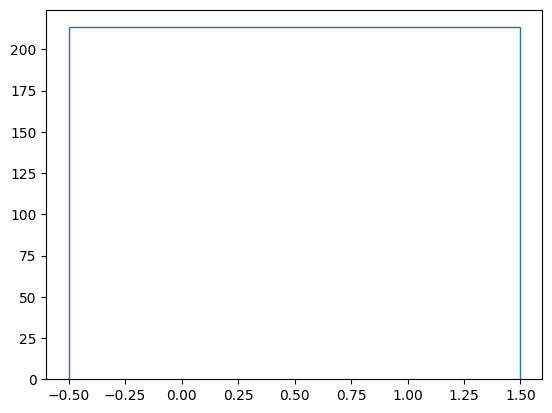

no signal


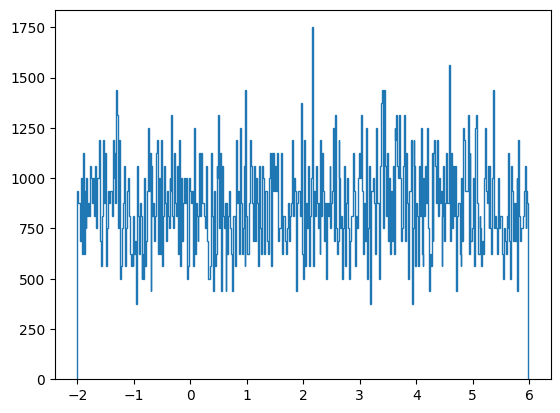

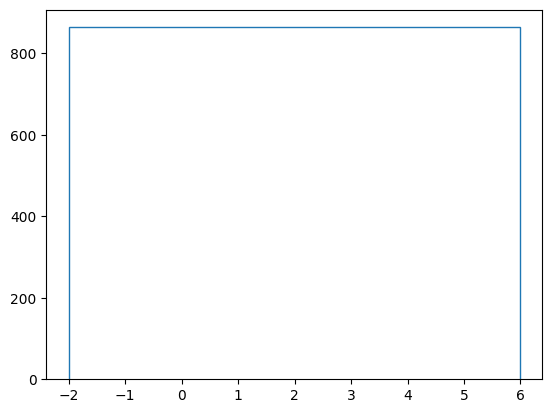

no signal


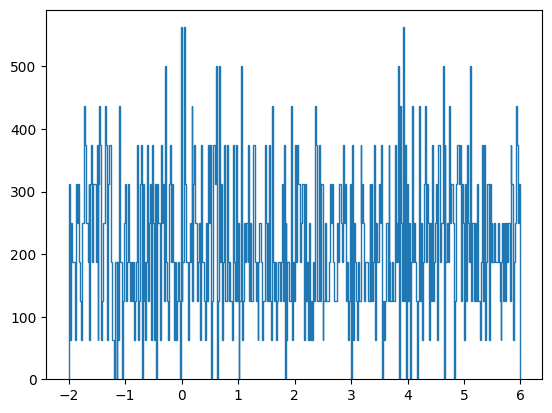

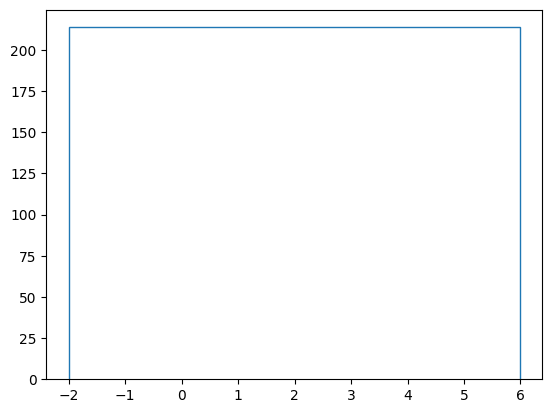

no signal


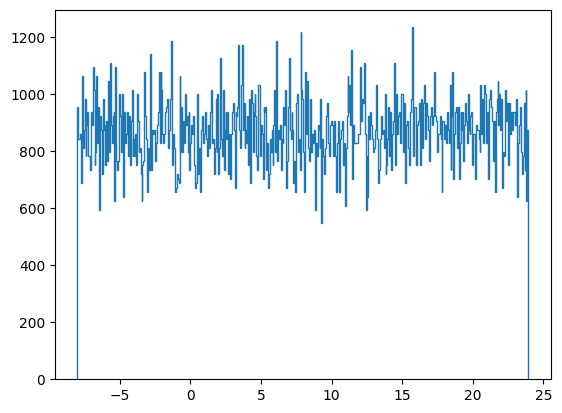

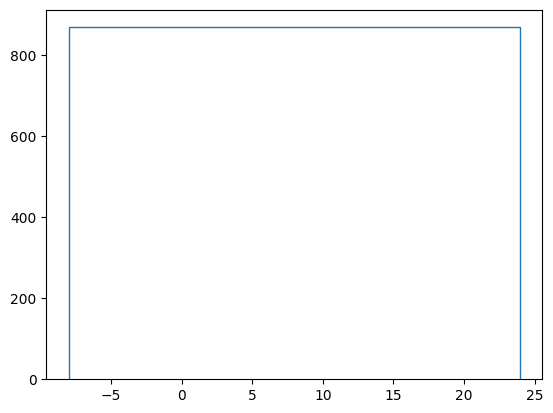

no signal


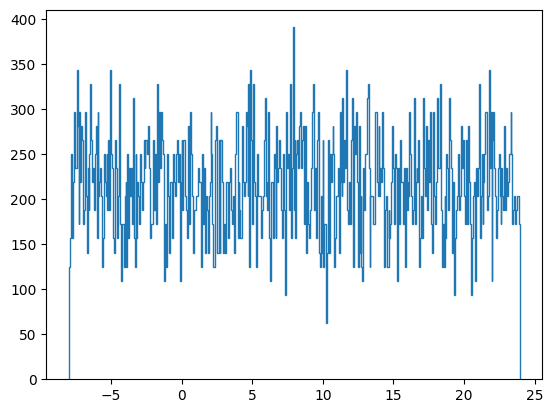

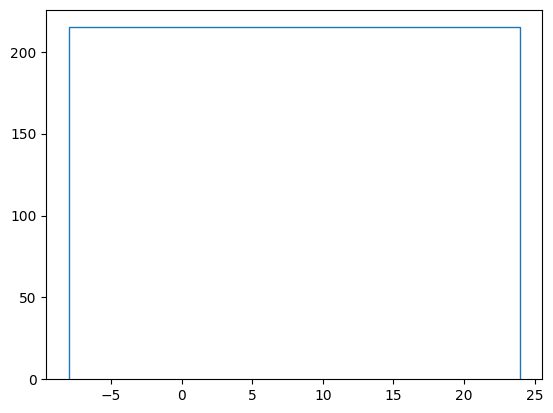

no signal


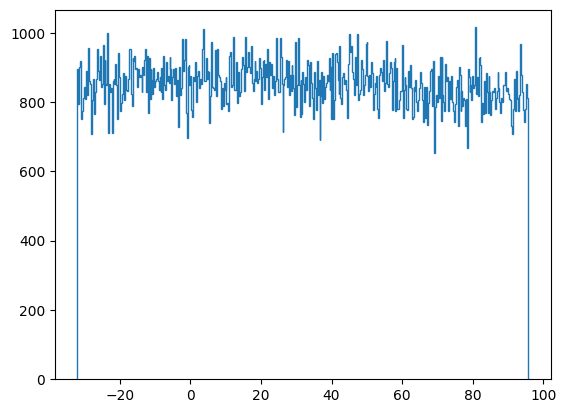

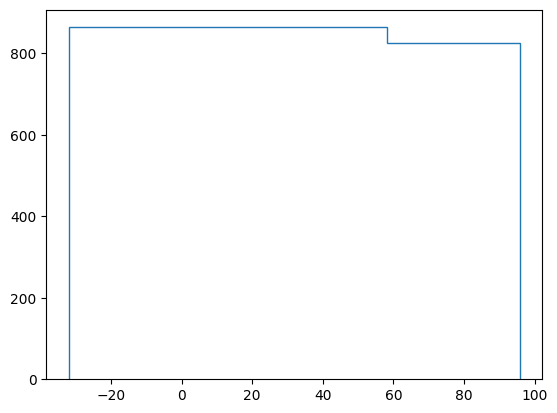

no signal


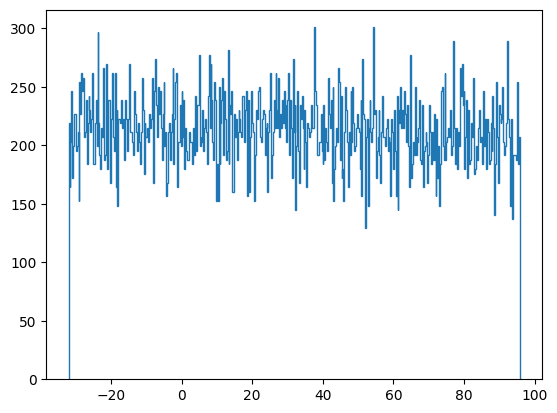

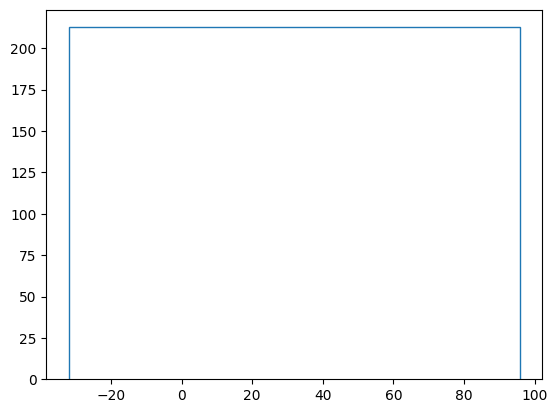

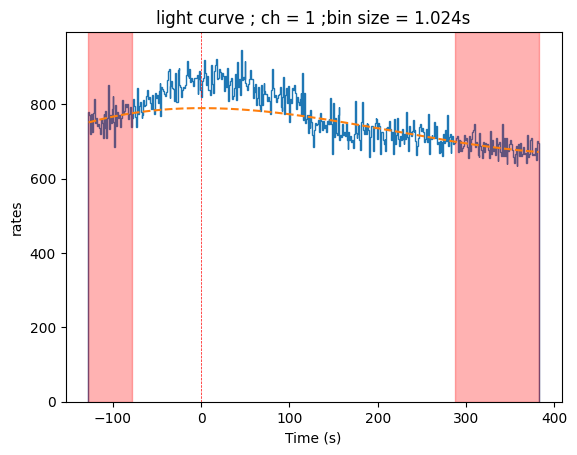

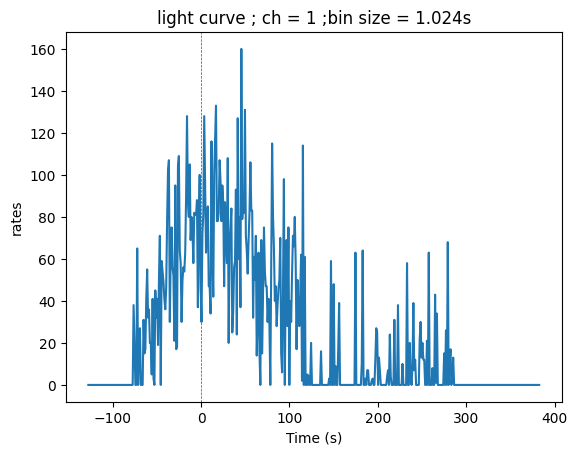

no signal


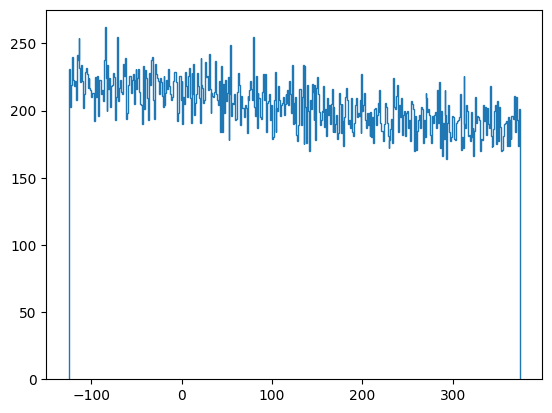

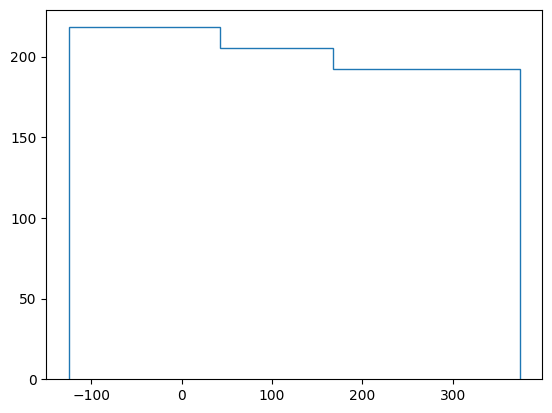

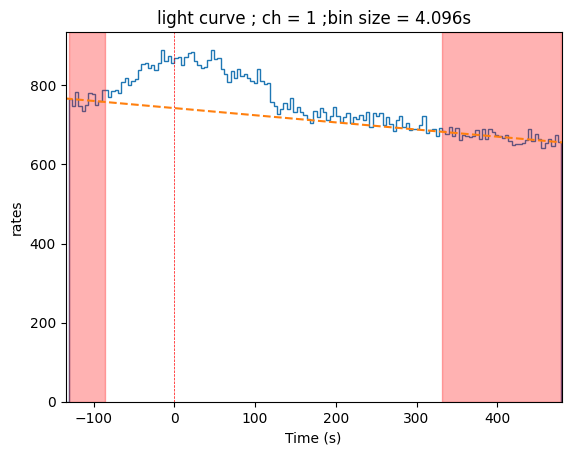

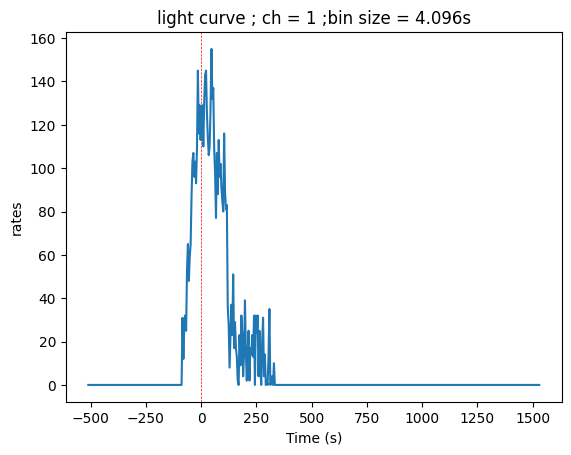

no signal


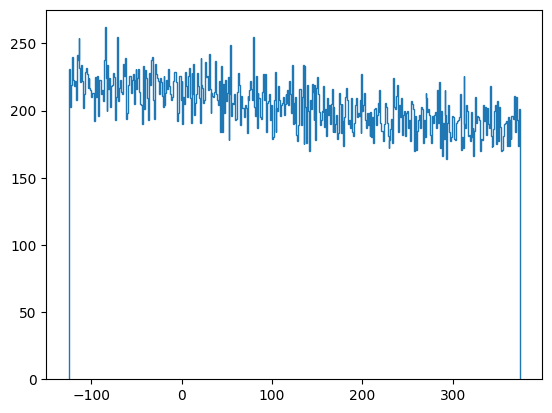

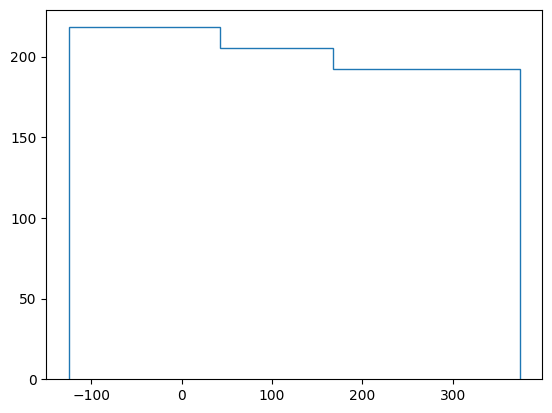

Processing folders:  20%|██        | 1/5 [00:38<02:33, 38.31s/folder]

shape (6986,)
no signal


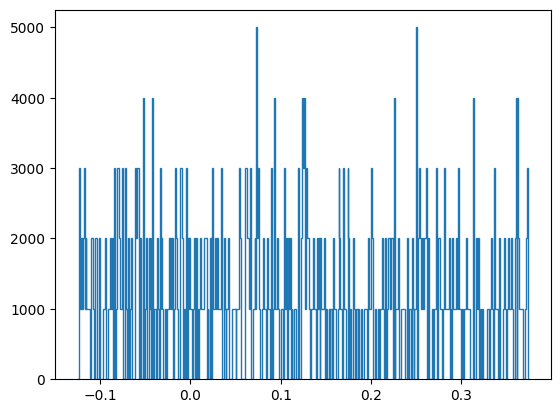

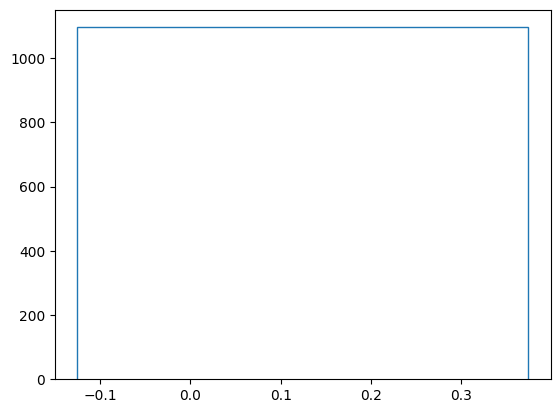

no signal


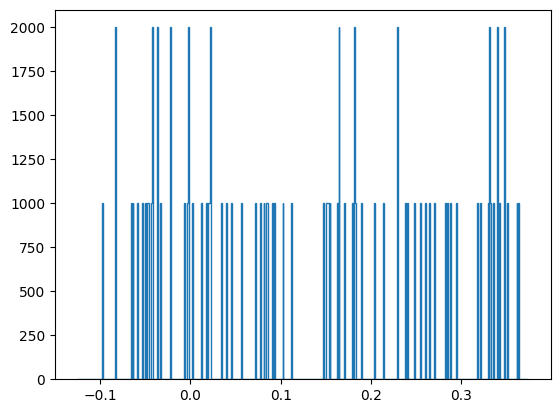

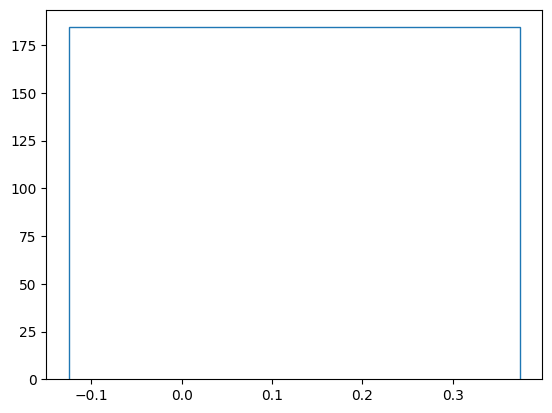

no signal


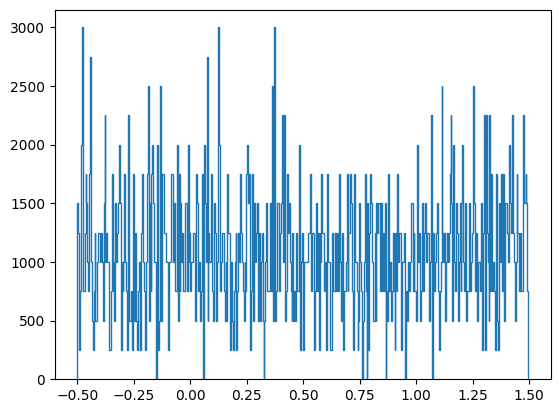

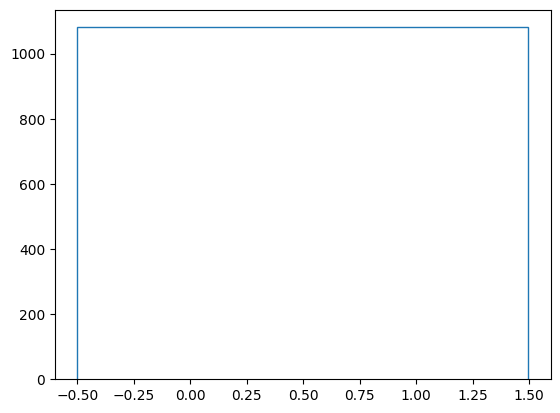

no signal


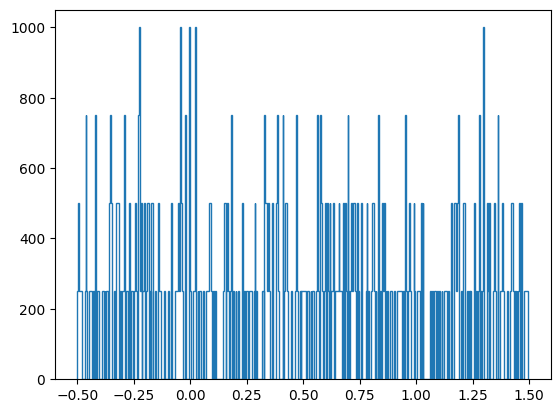

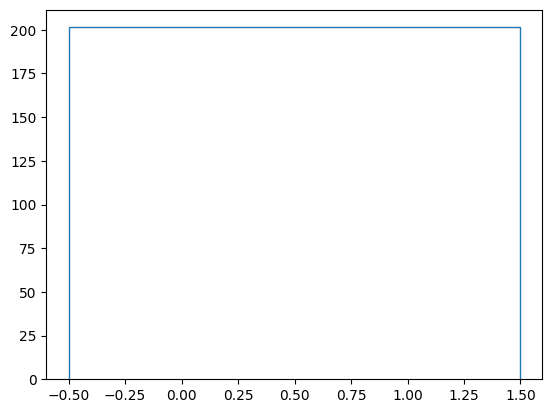

no signal


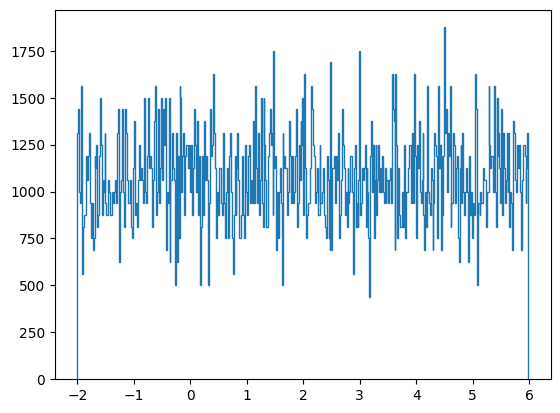

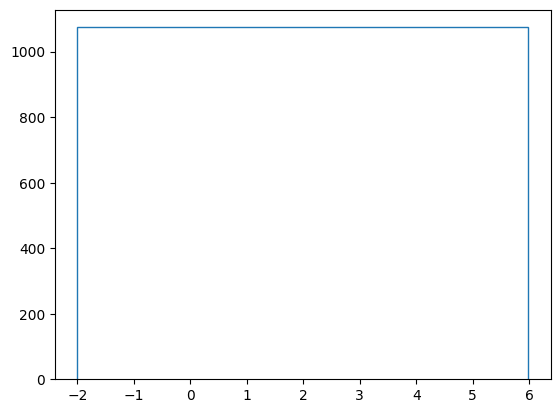

no signal


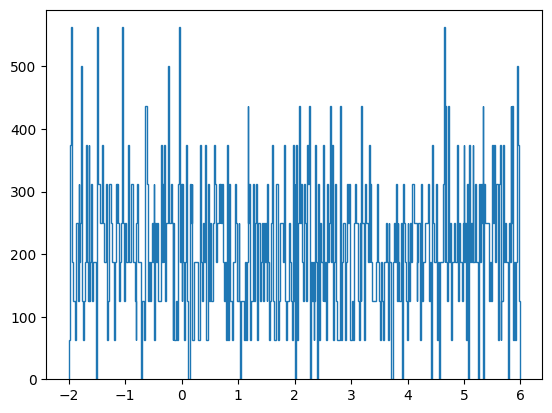

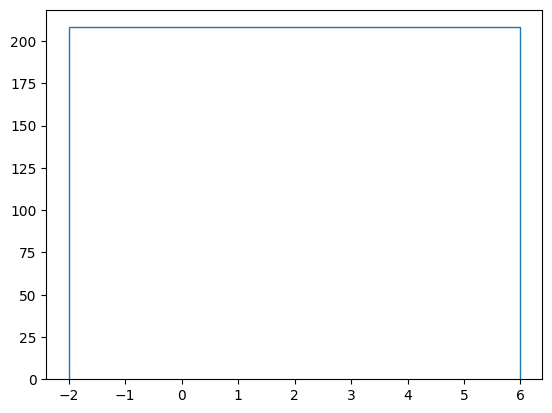

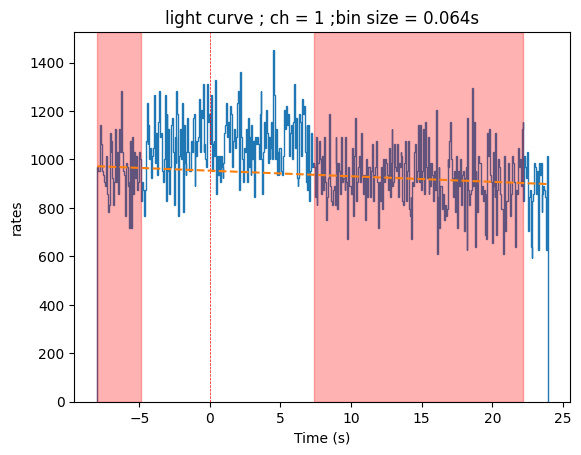

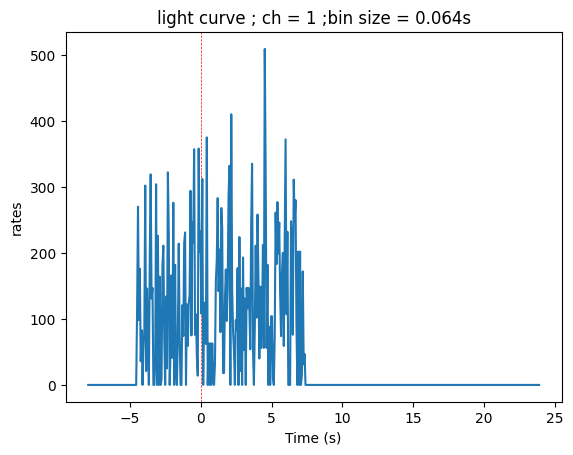

no signal


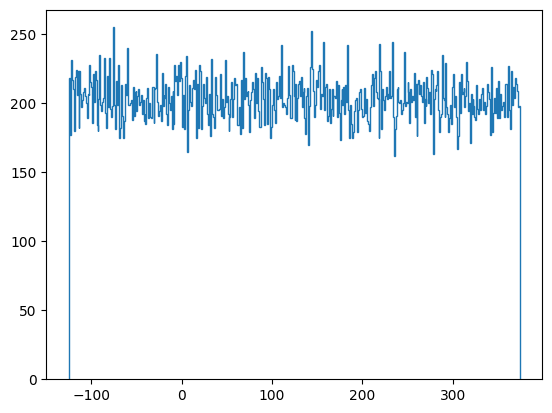

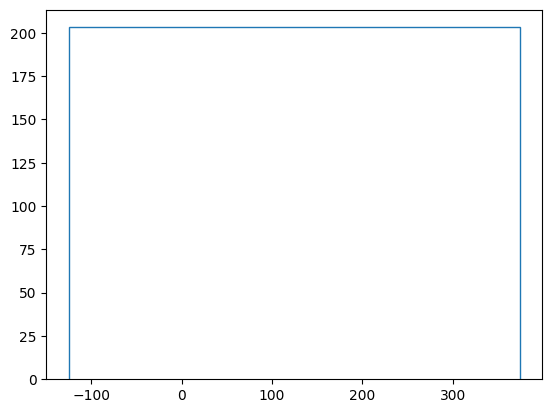

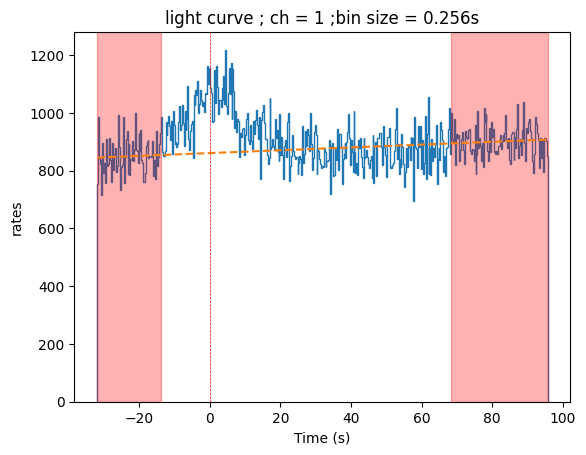

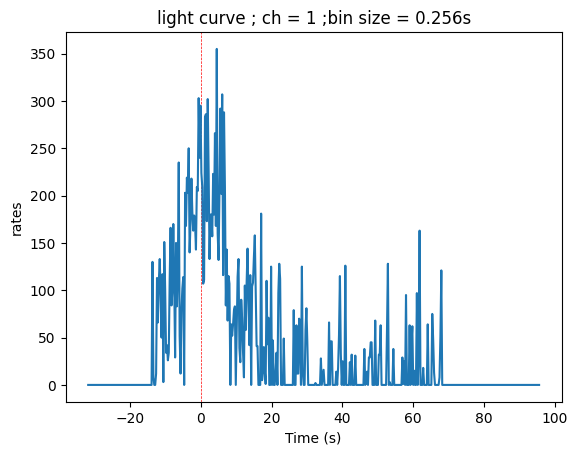

no signal


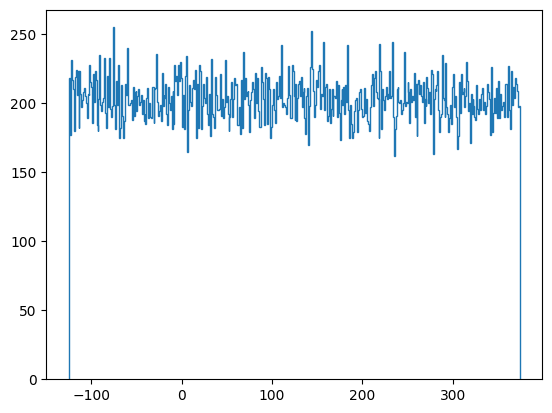

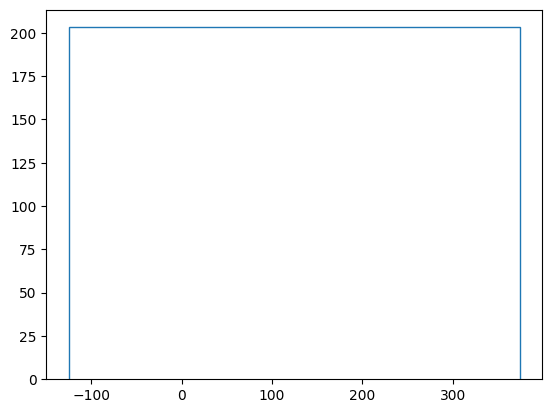

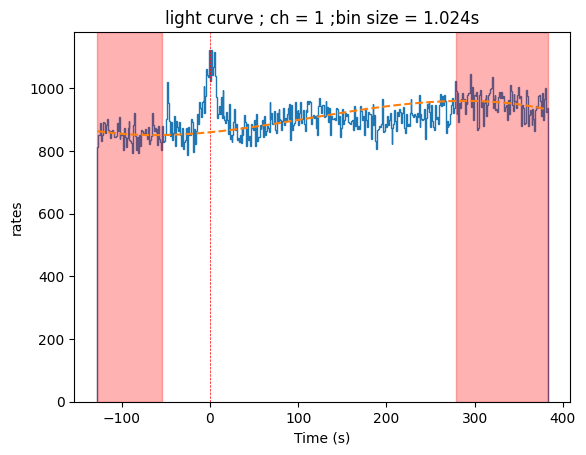

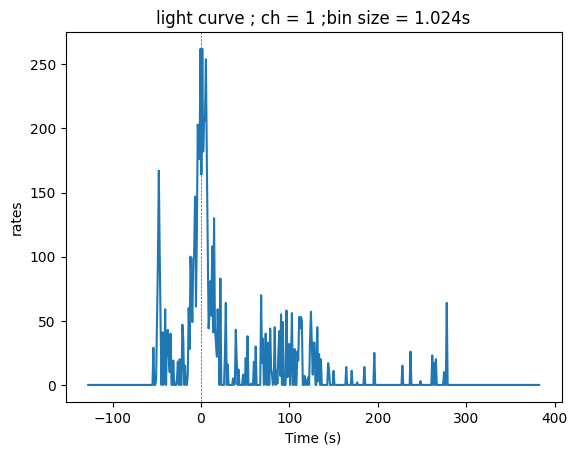

no signal


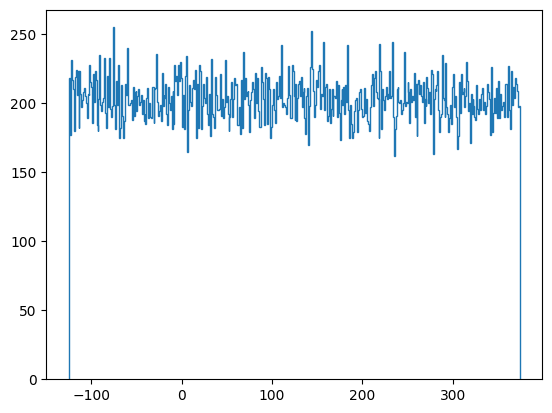

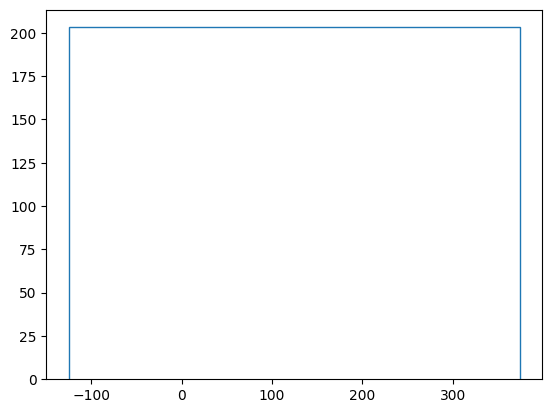

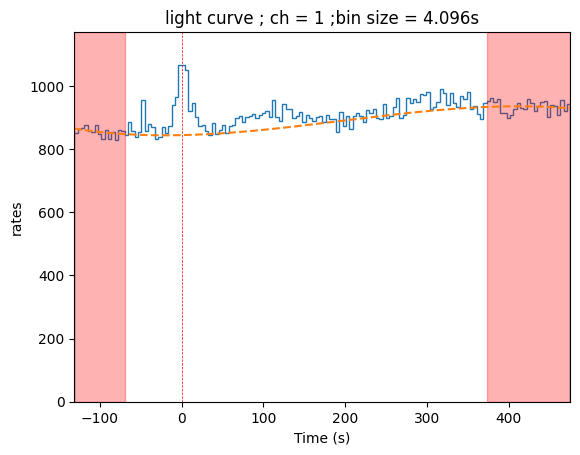

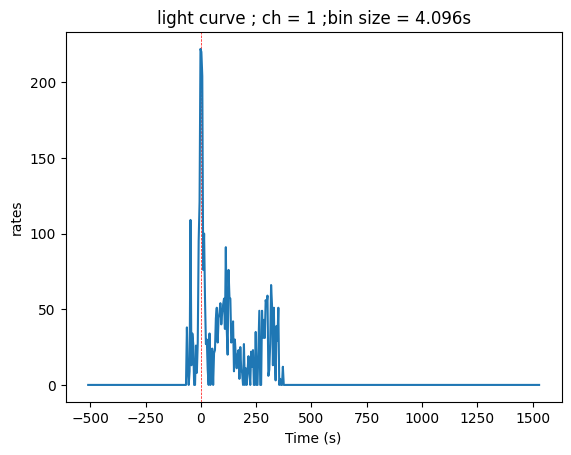

no signal


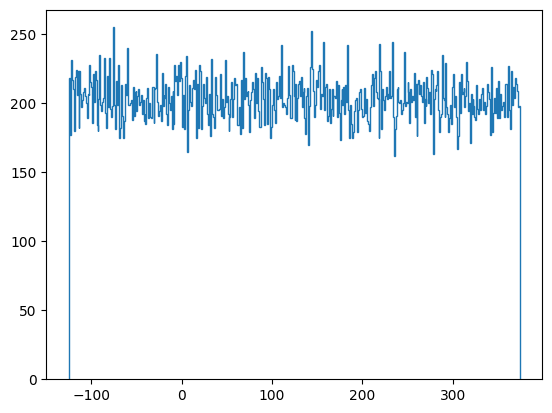

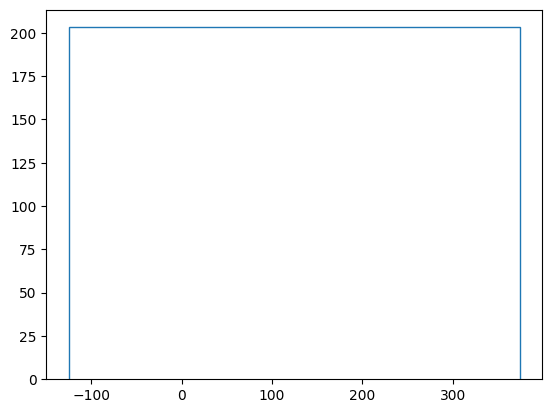

Processing folders:  40%|████      | 2/5 [01:12<01:48, 36.12s/folder]

shape (6986,)
no signal


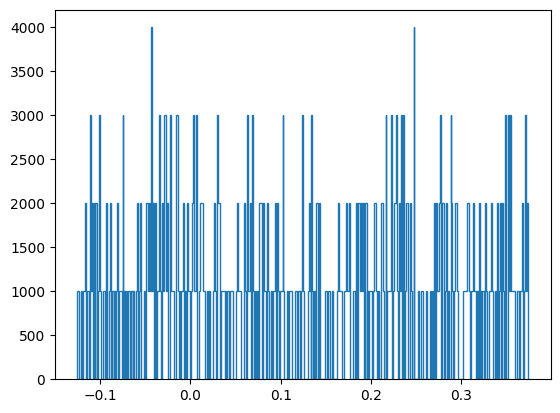

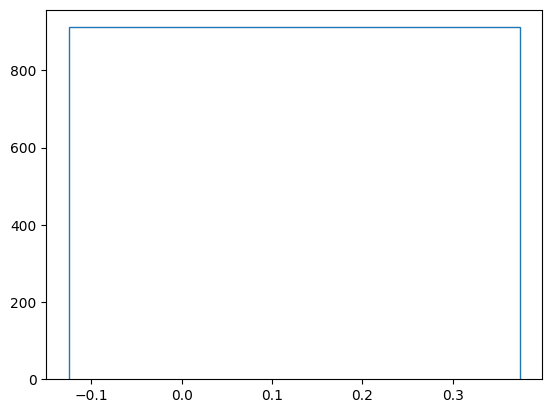

no signal


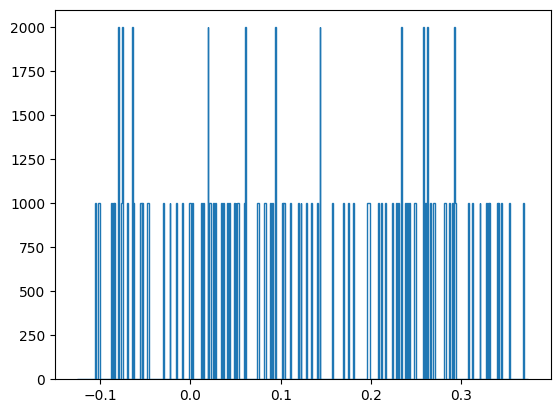

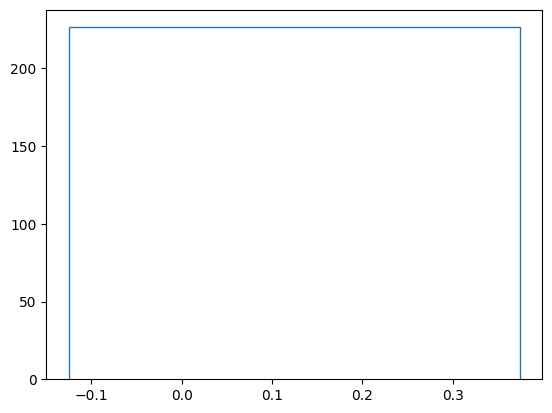

no signal


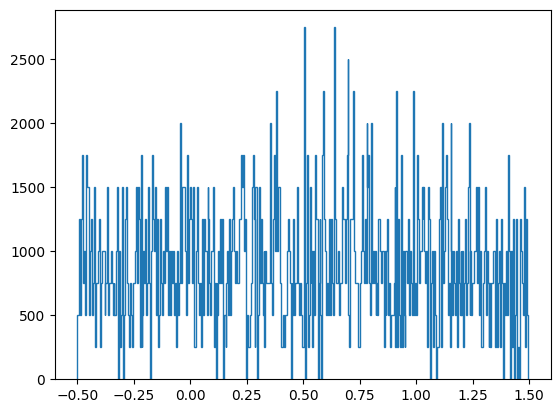

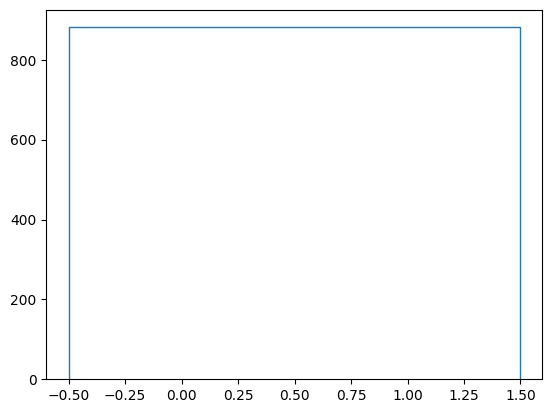

no signal


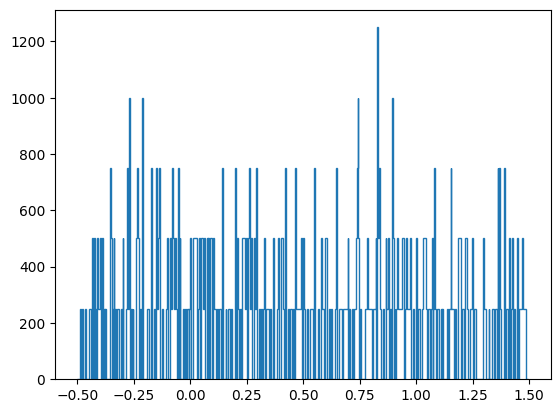

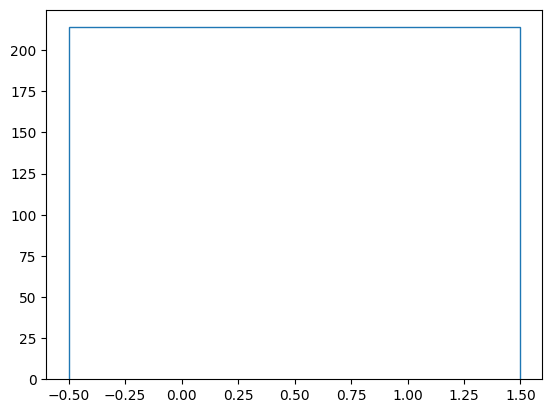

no signal


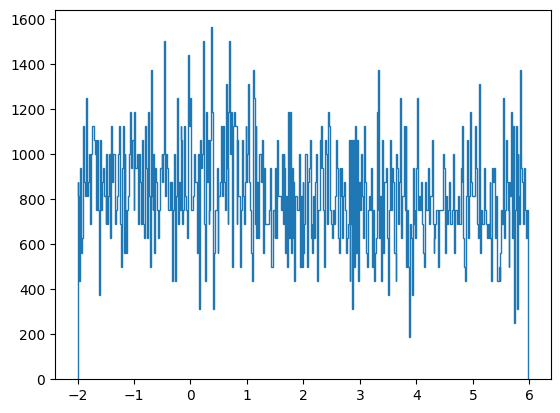

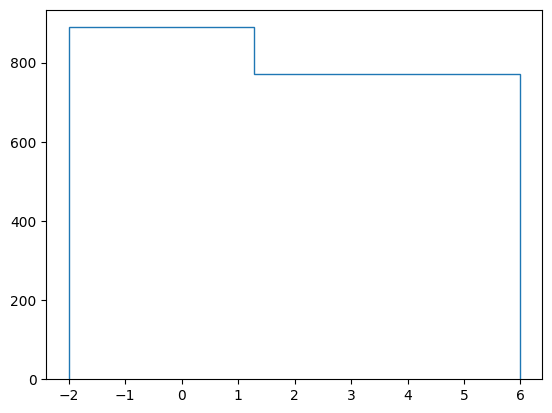

no signal


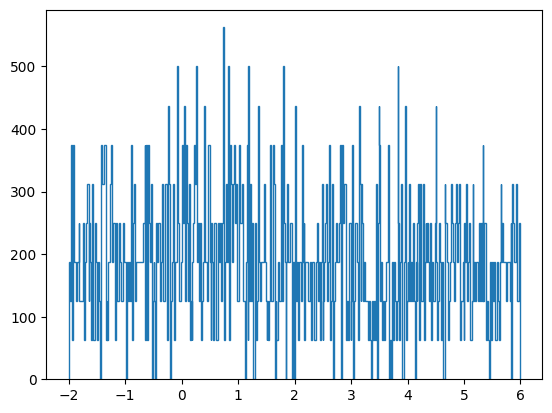

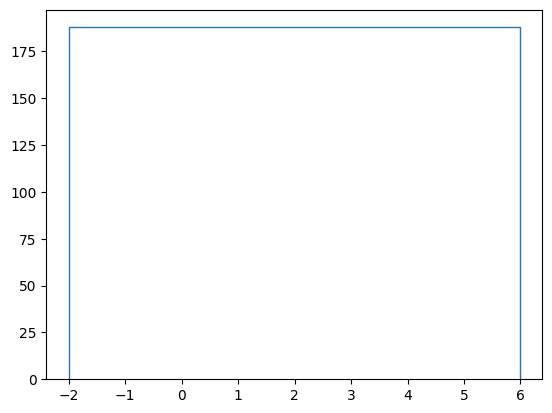

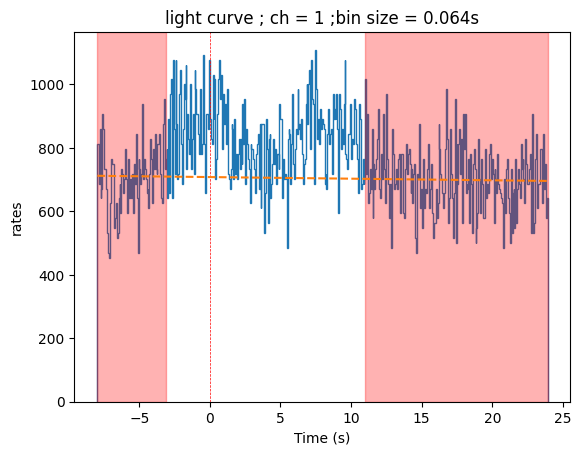

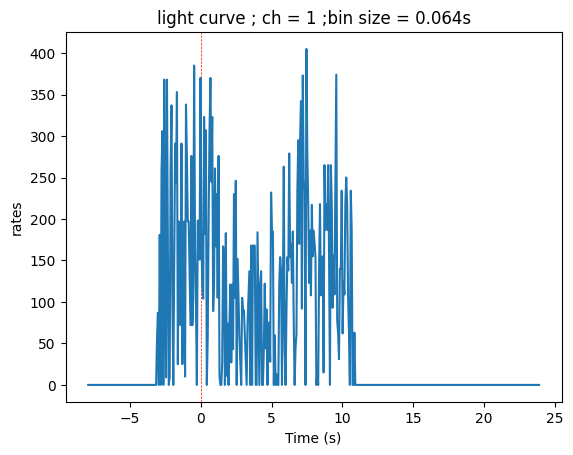

no signal


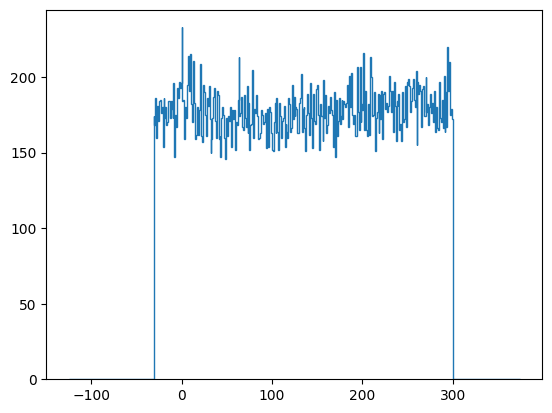

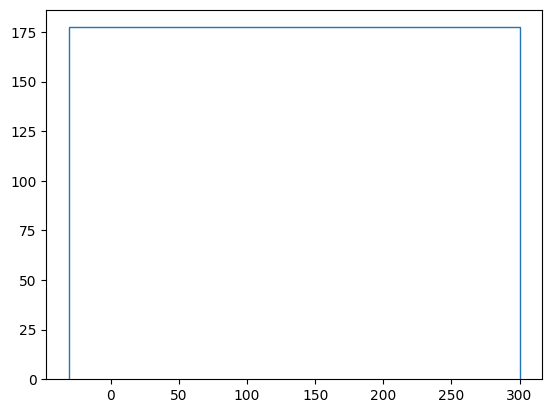

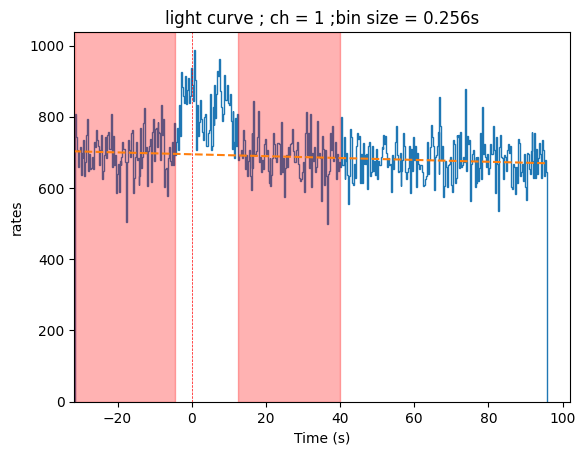

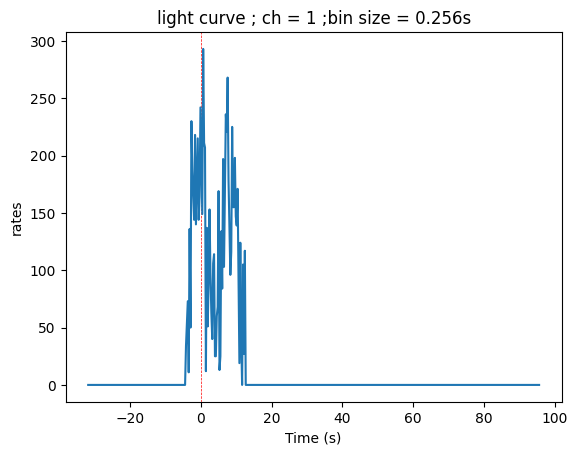

no signal


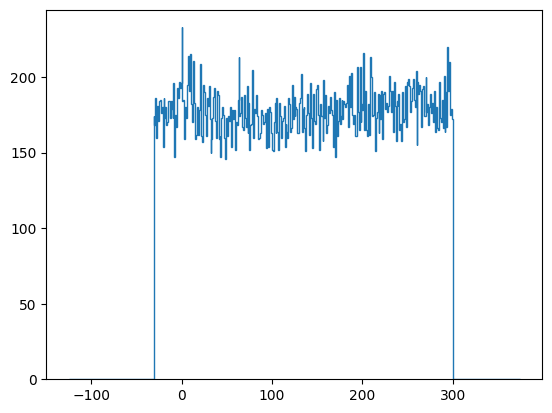

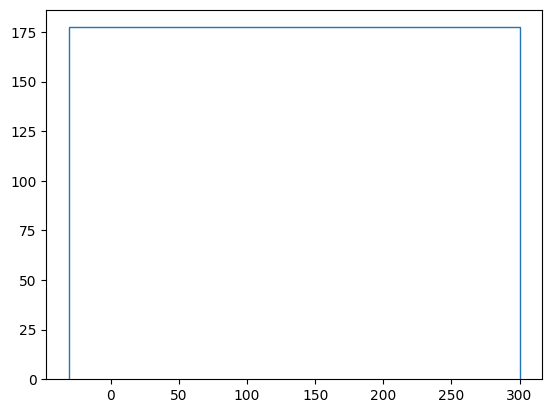

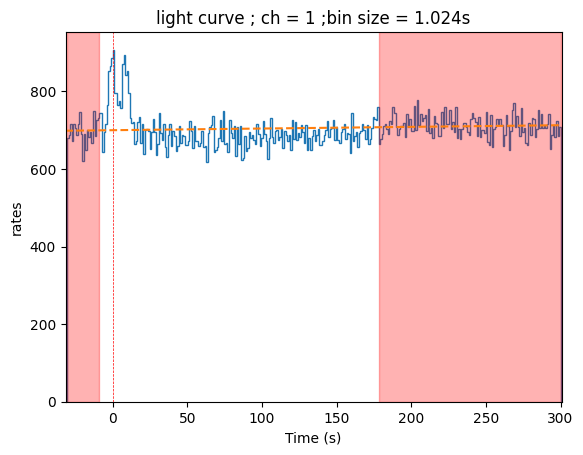

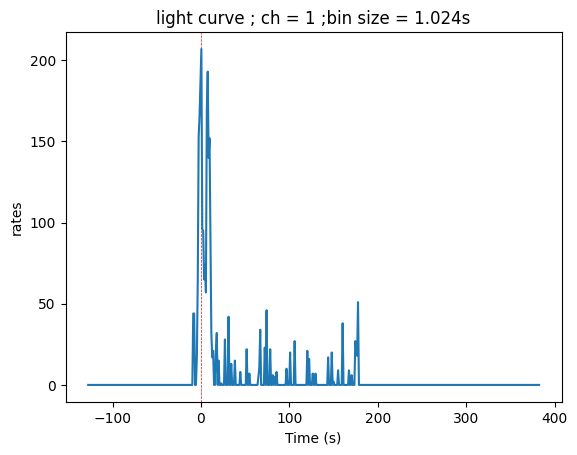

no signal


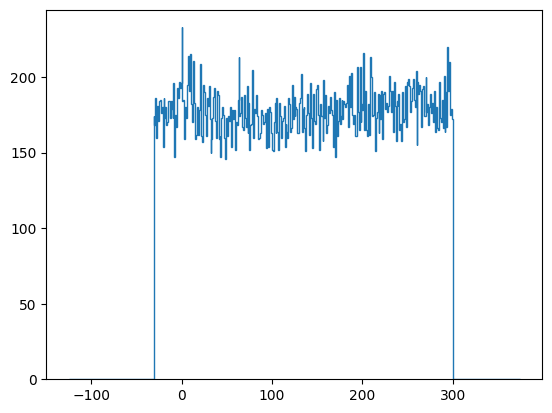

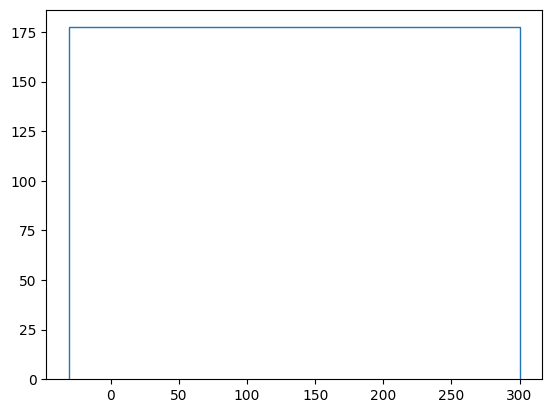

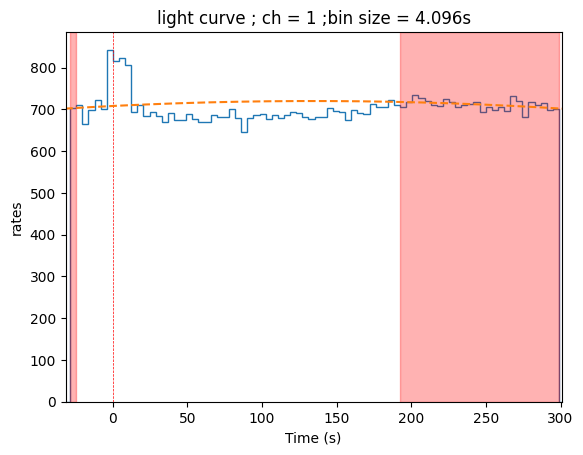

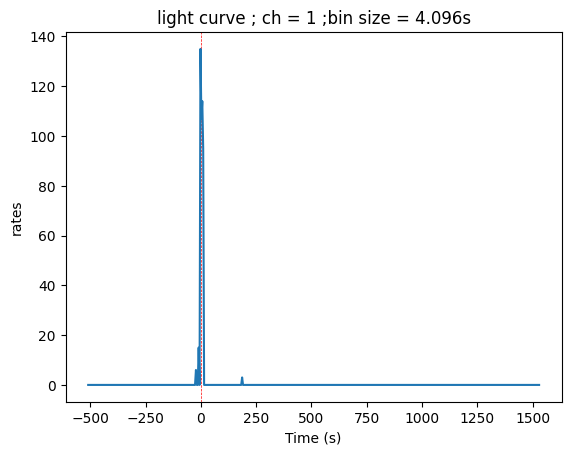

no signal


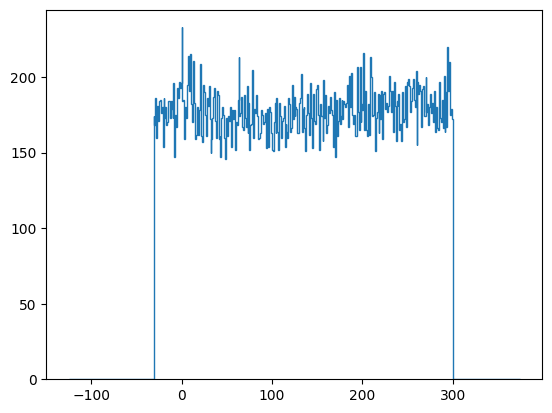

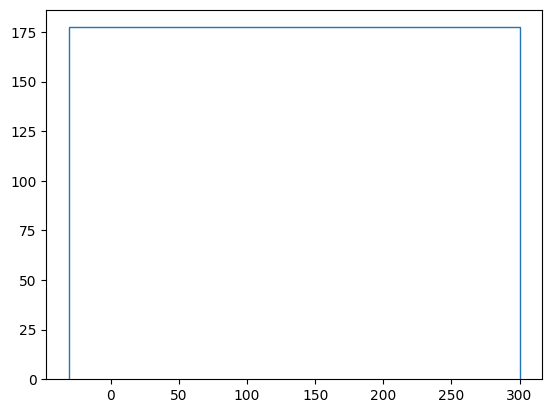

Processing folders:  60%|██████    | 3/5 [01:47<01:10, 35.46s/folder]

shape (6986,)


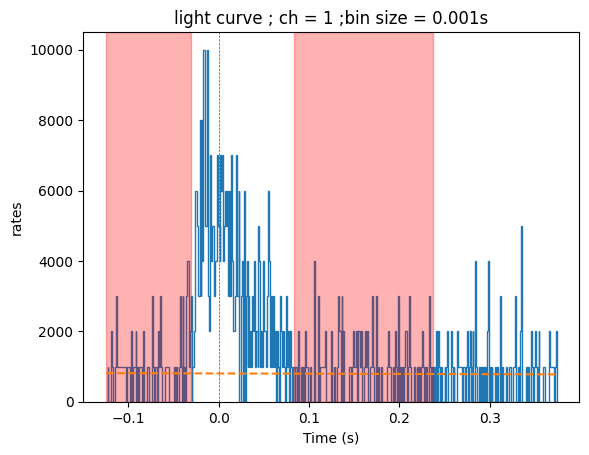

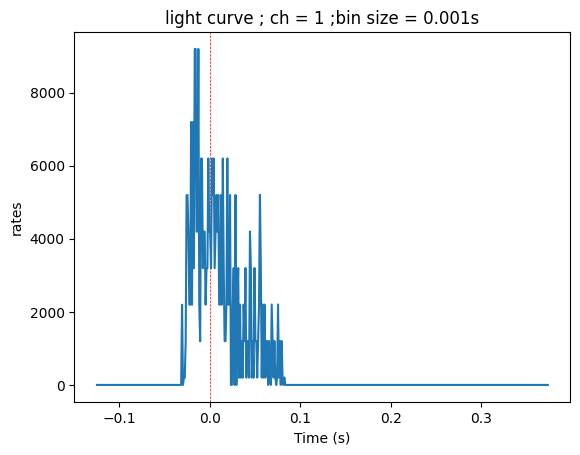

no signal


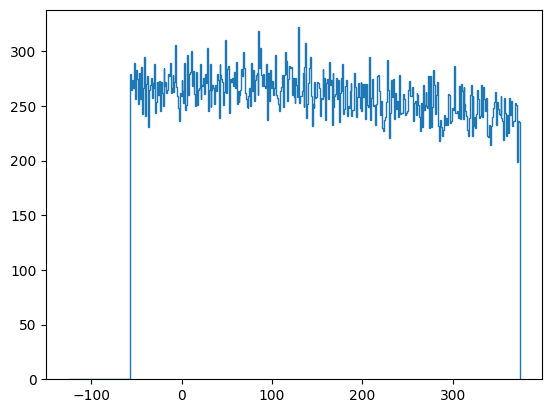

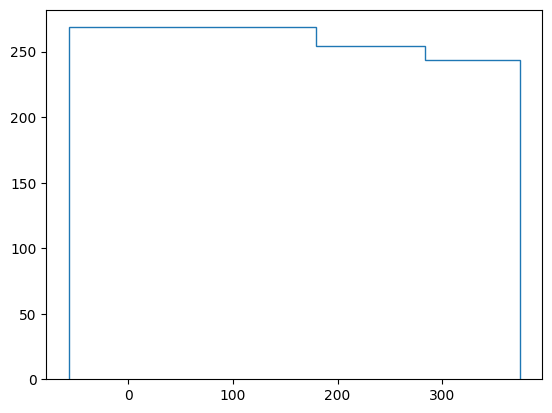

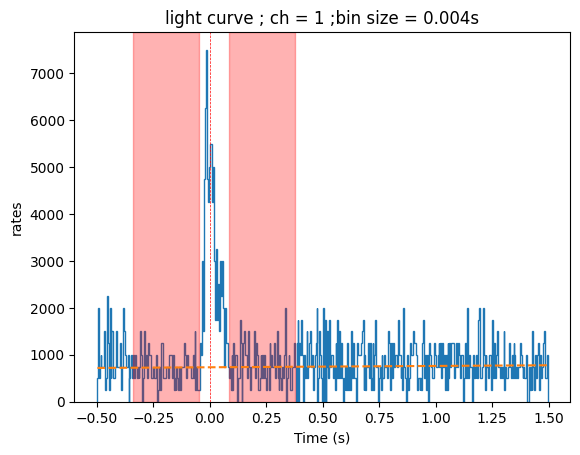

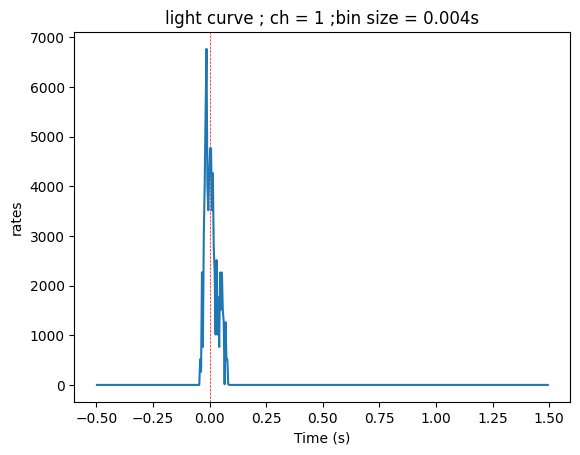

no signal


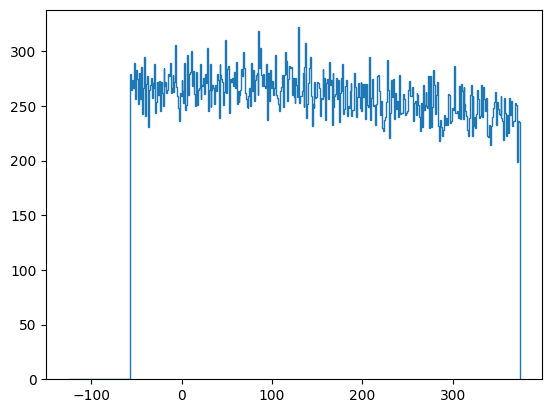

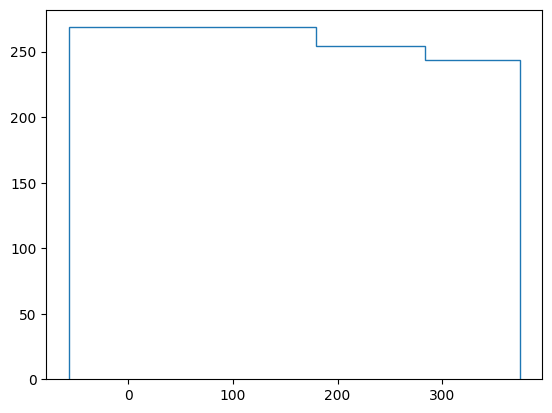

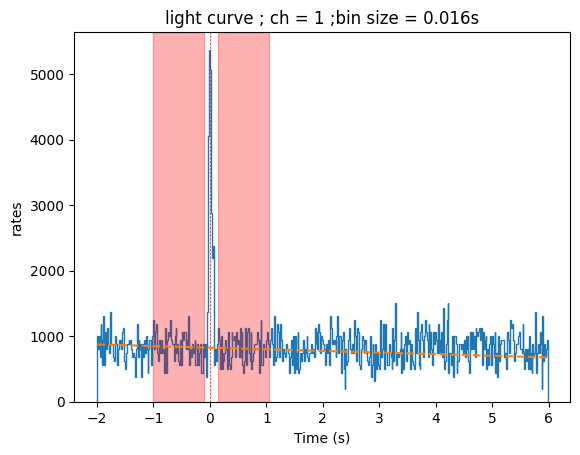

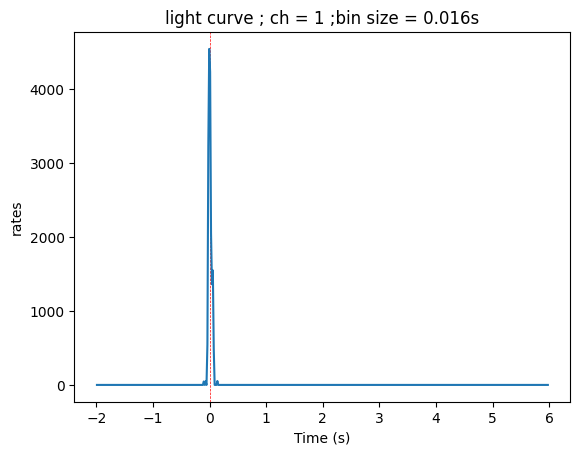

no signal


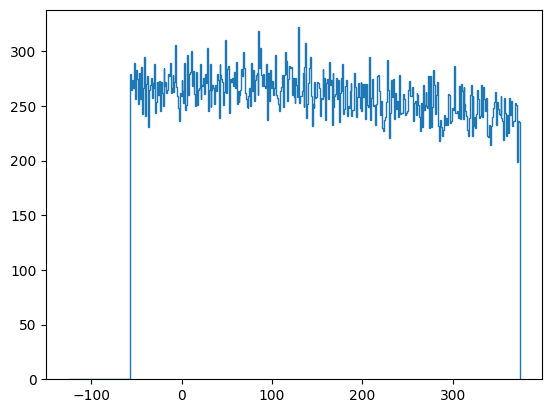

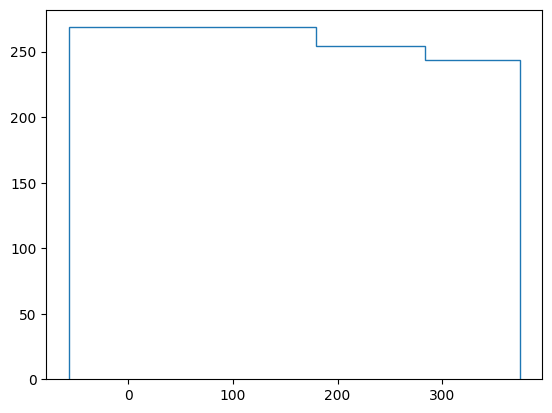

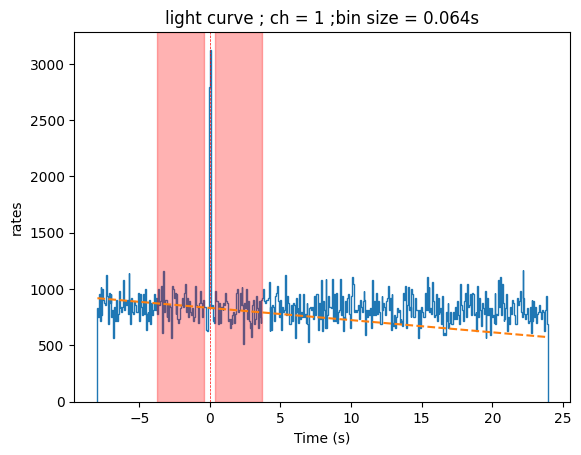

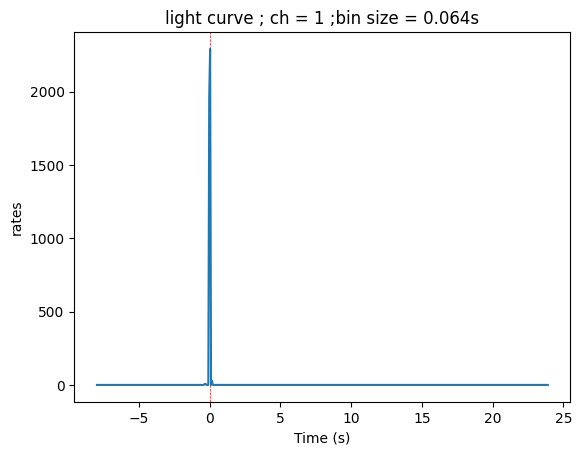

no signal


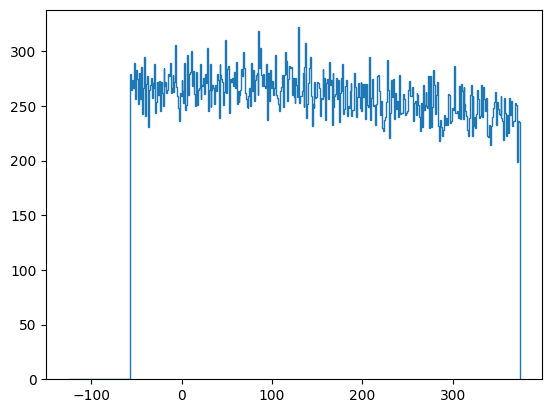

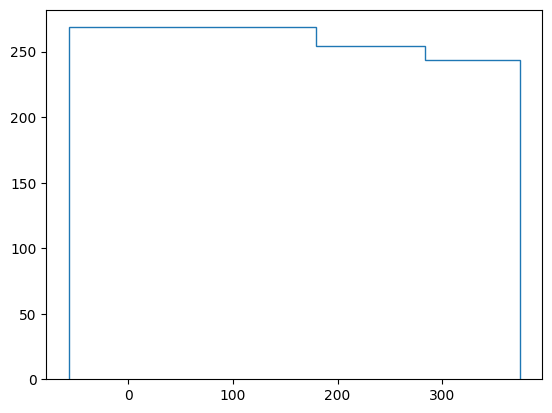

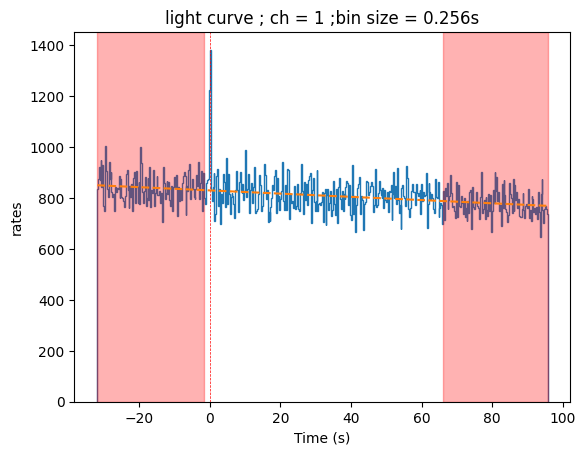

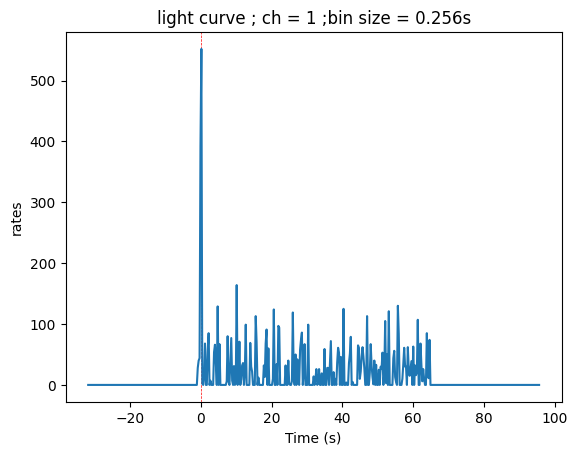

no signal


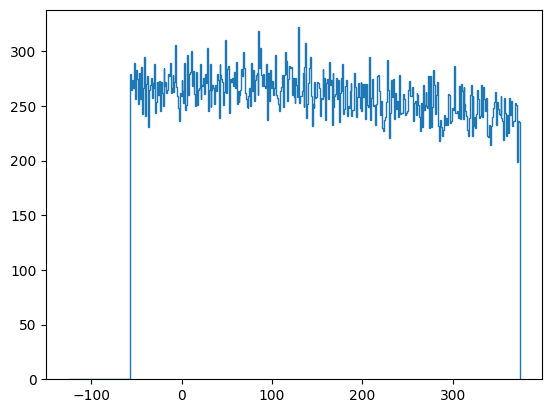

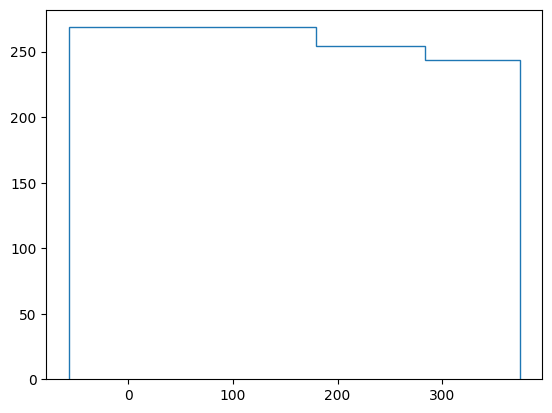

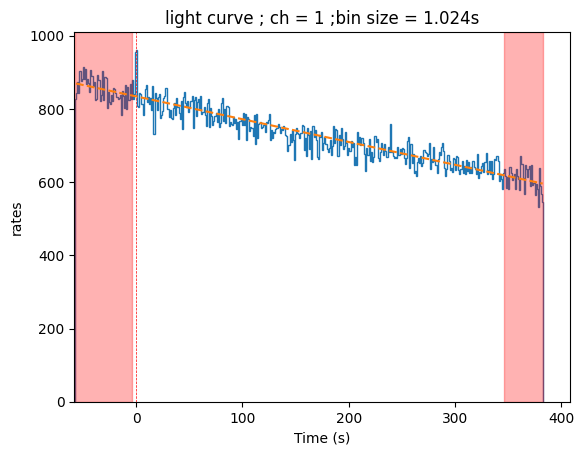

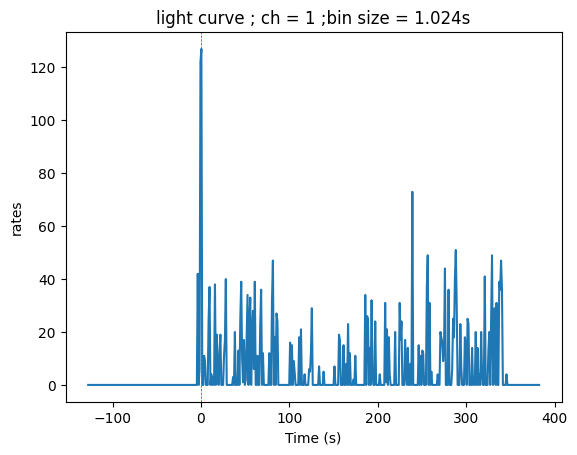

no signal


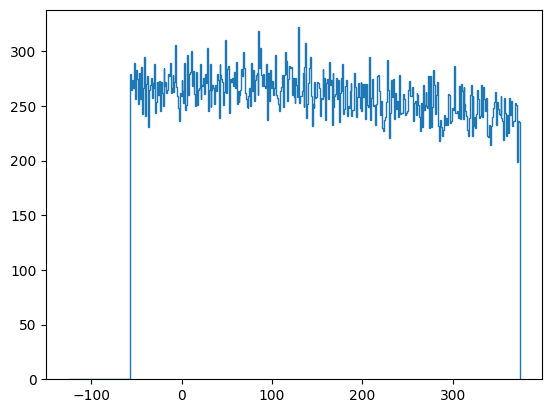

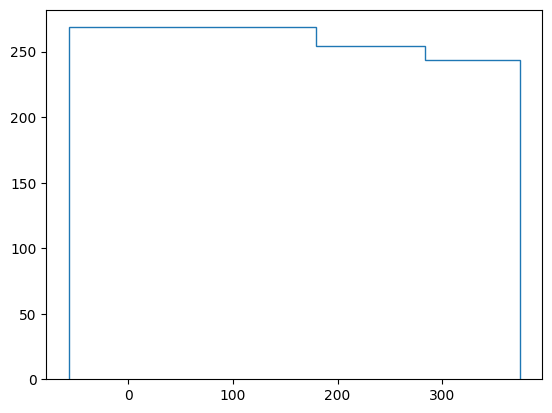

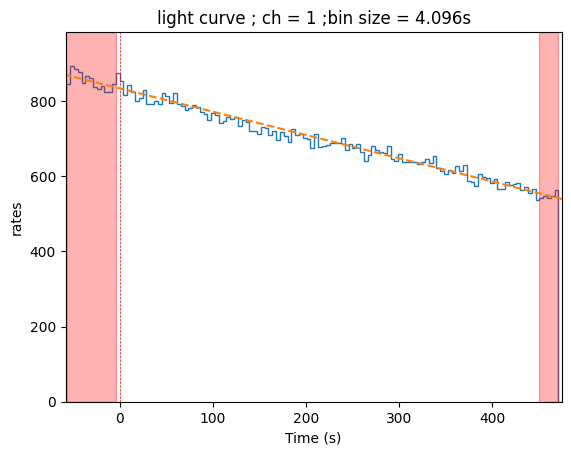

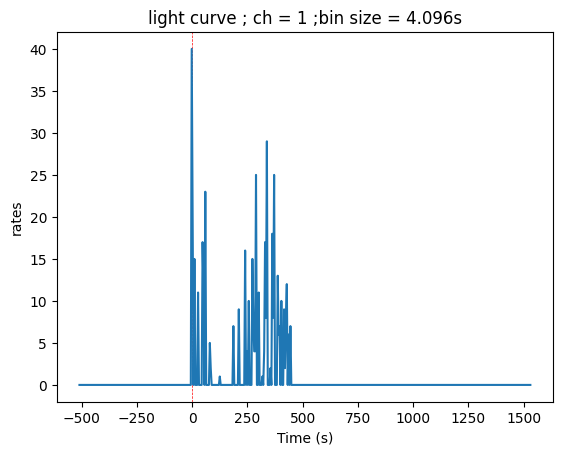

no signal


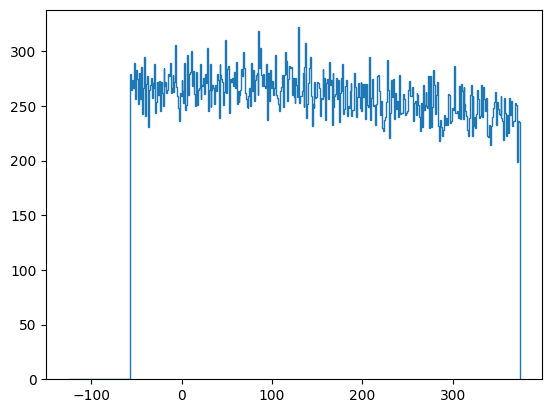

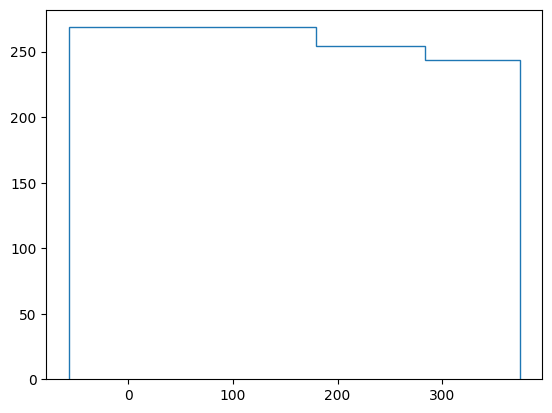

Processing folders:  80%|████████  | 4/5 [02:21<00:35, 35.04s/folder]

shape (6986,)
no signal


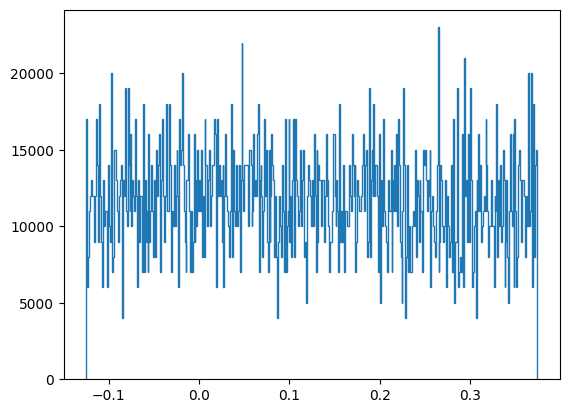

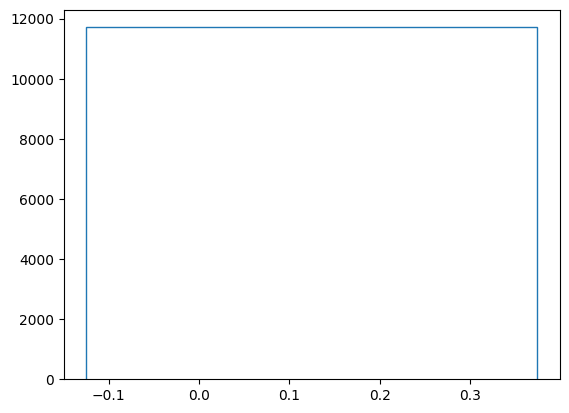

no signal


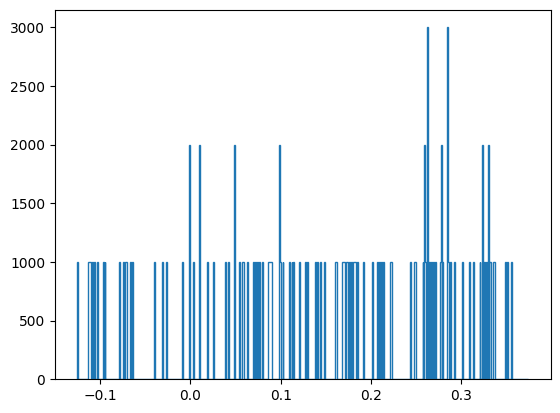

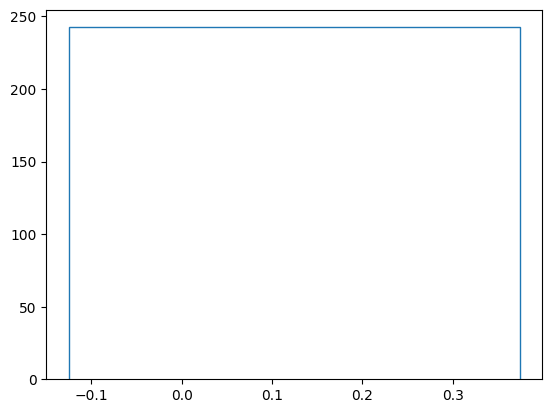

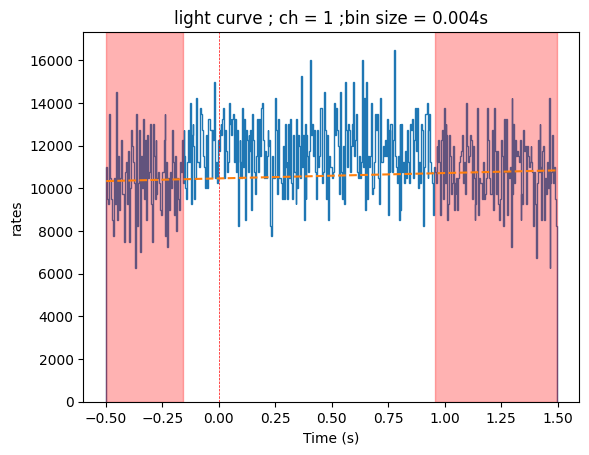

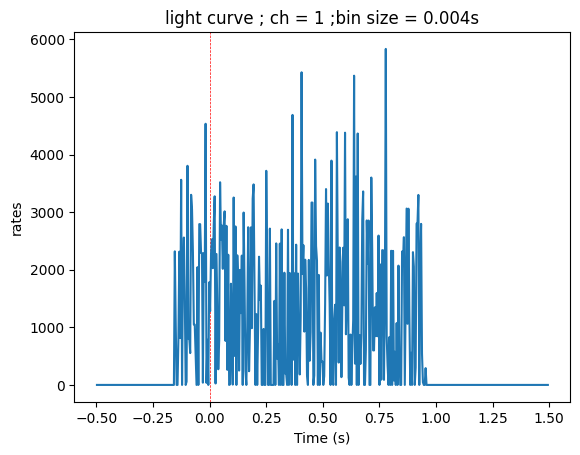

no signal


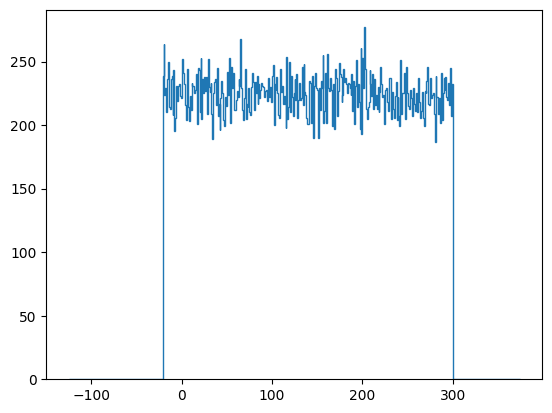

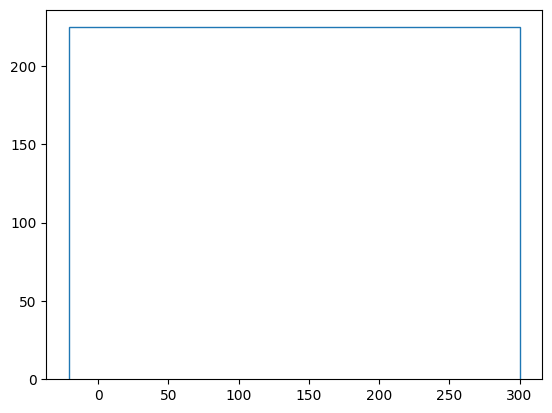

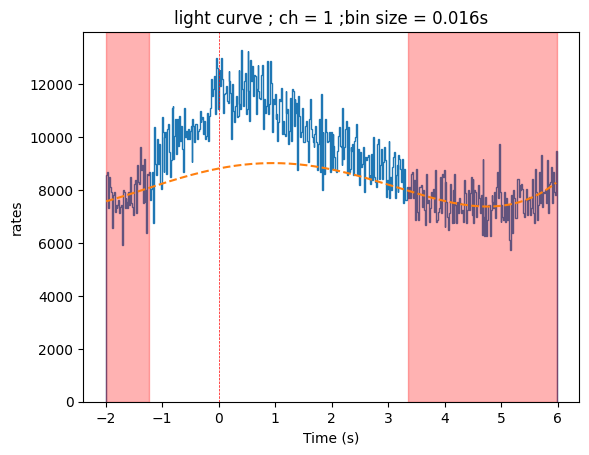

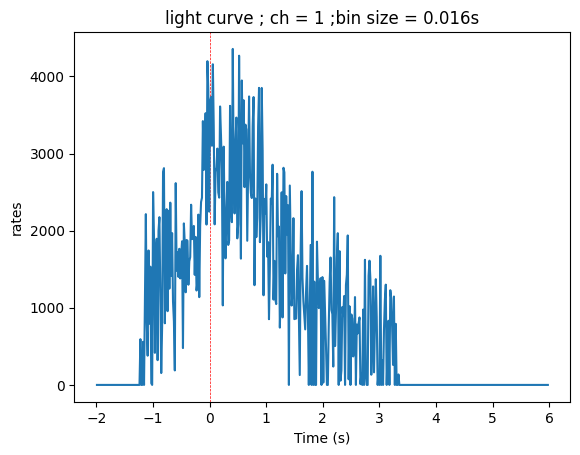

no signal


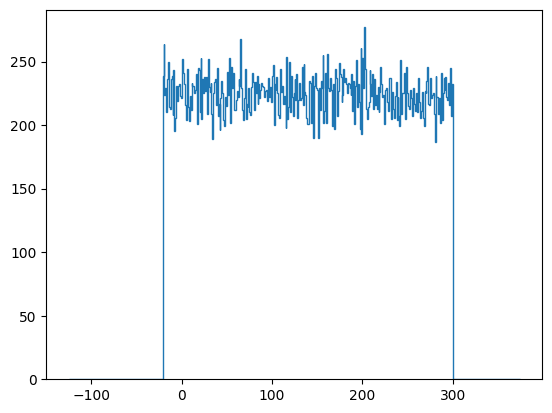

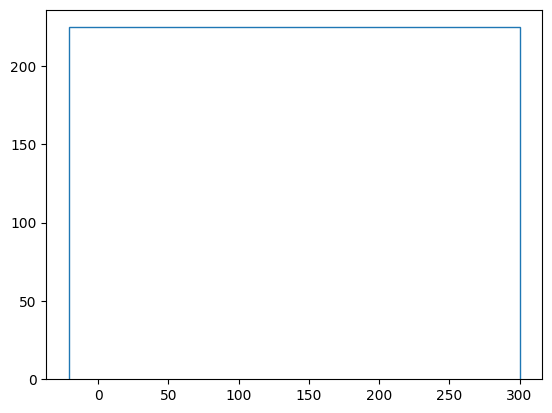

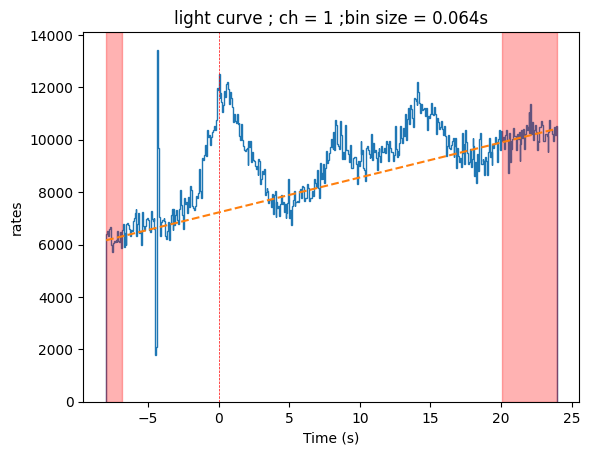

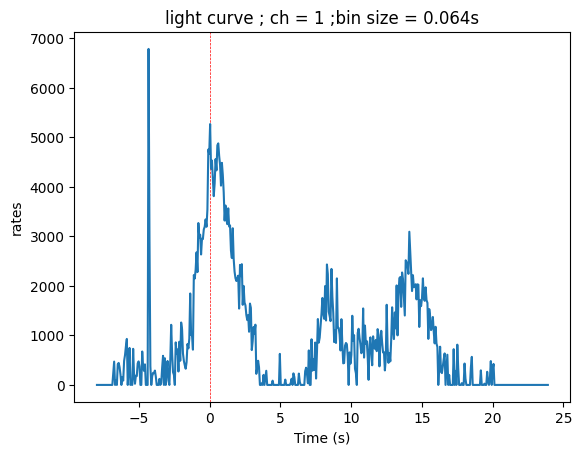

no signal


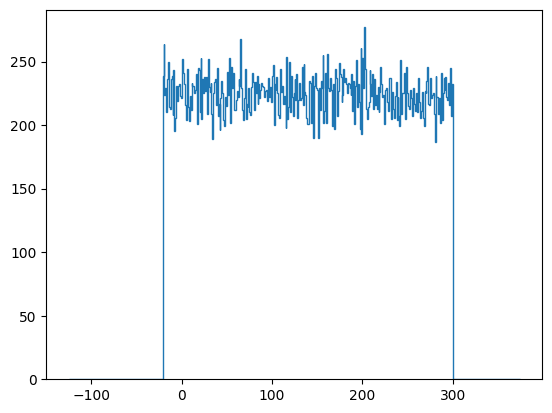

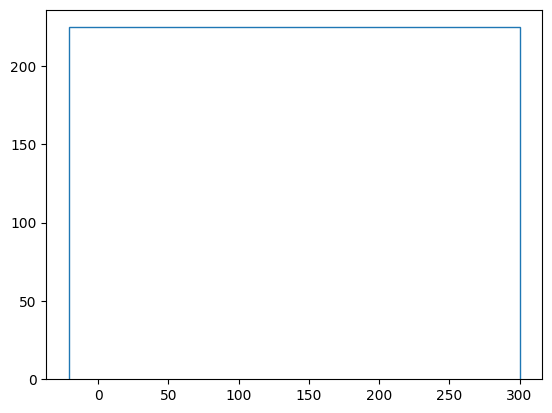

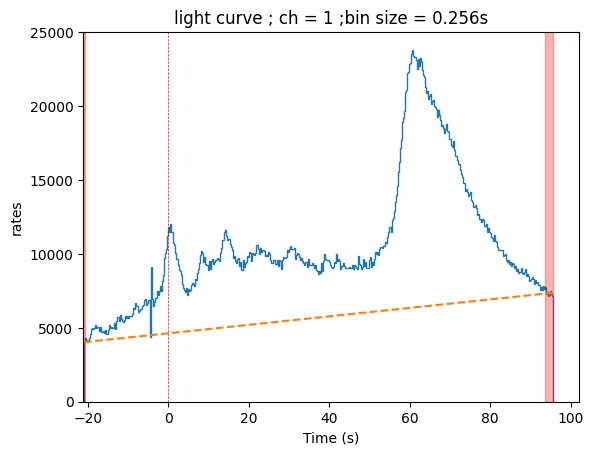

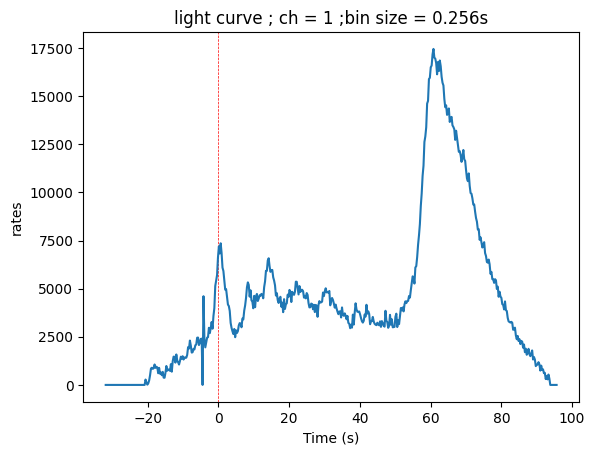

no signal


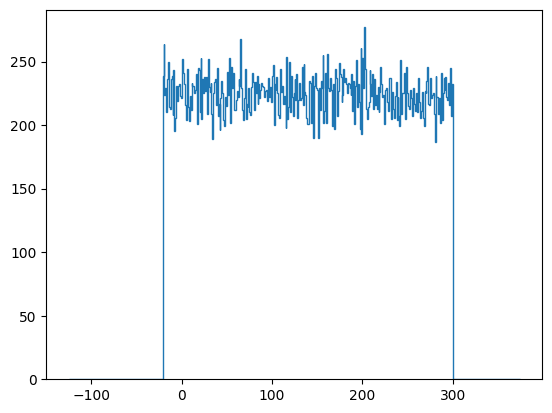

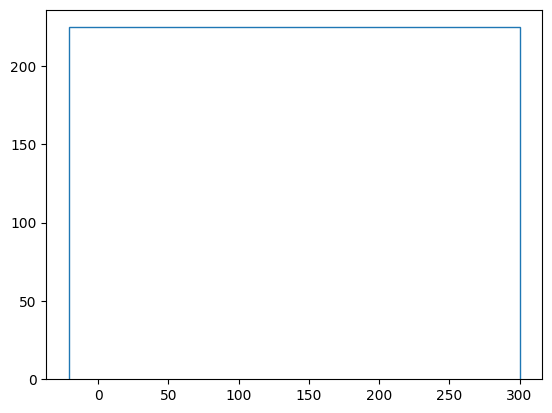

no signal


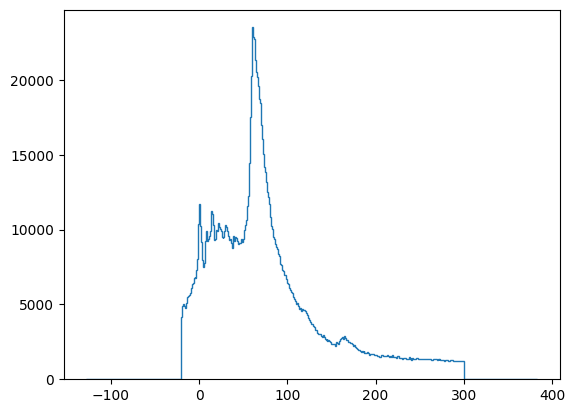

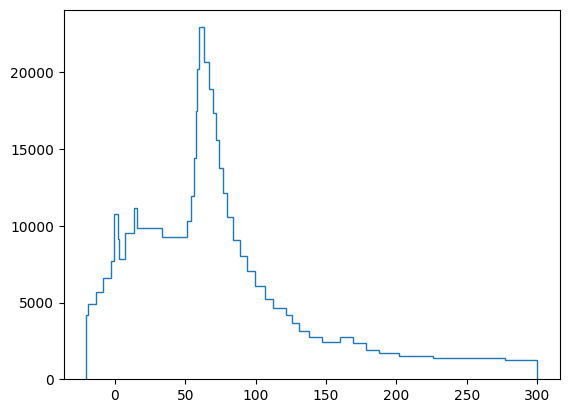

no signal


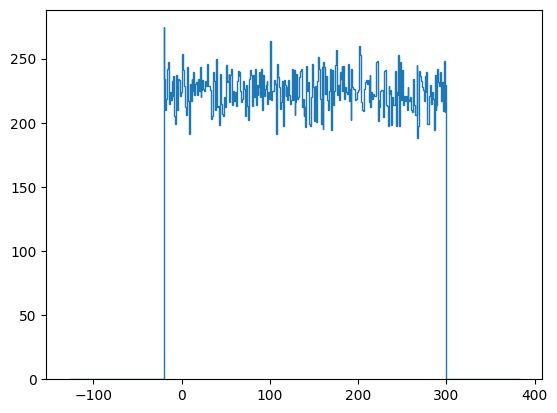

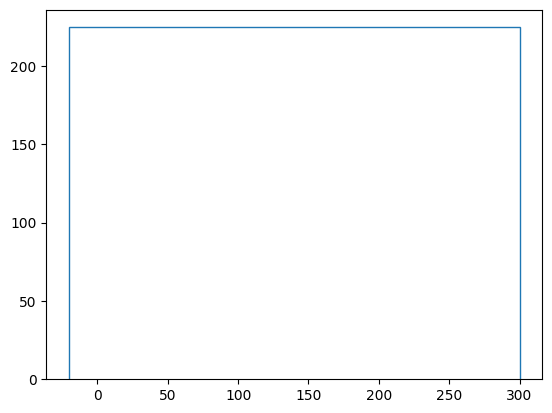

no signal


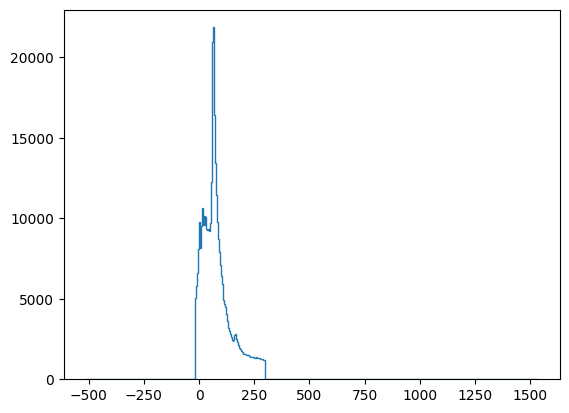

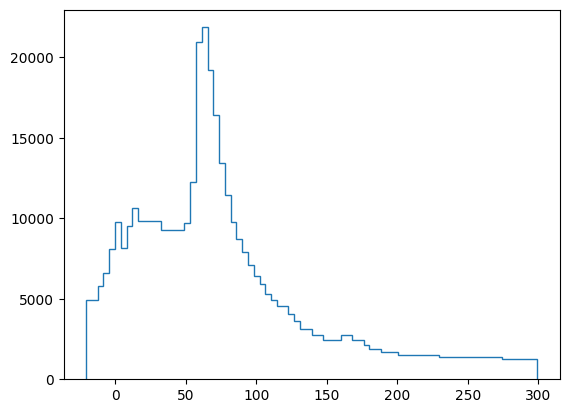

no signal


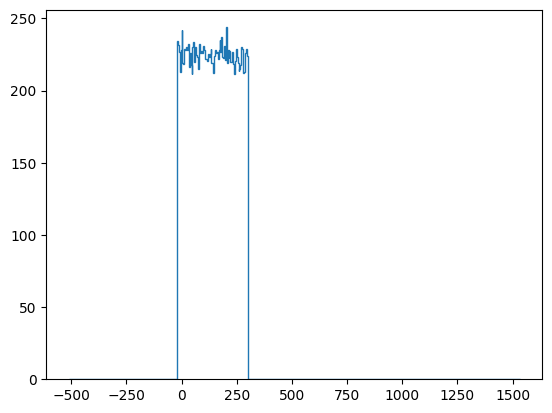

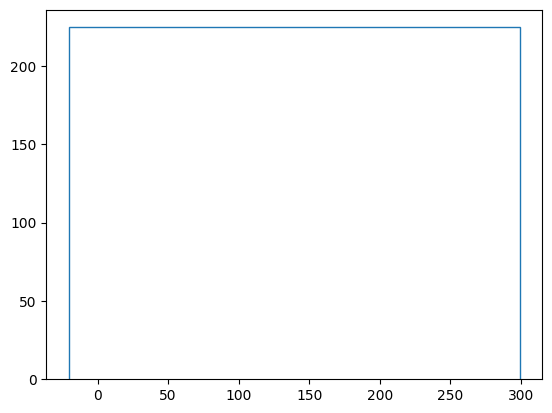

Processing folders: 100%|██████████| 5/5 [02:56<00:00, 35.37s/folder]

shape (6986,)
Timer unit: 1e-07 s

Total time: 176.79 s
File: C:\Users\arpan\AppData\Local\Temp\ipykernel_40492\989561297.py
Function: process_folder at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                           @profile
    32                                           def process_folder(folder, bin_list,data_no,r,chr1,chr2,data_set_path,source_data_set_path,error_folders,zero_files = zero_files, plot = False):
    33                                               """
    34                                               Process a single folder of data.
    35                                               
    36                                               :param folder: Name of the folder to process
    37                                               :param bin_list: List of bin sizes to use
    38                                               """
    39         5        117.0     23.4      0.0      try:
    40            

In [5]:
if True:
    # name of the data set
    source_data_set_path = r"D:\GRB_data\500_data_set"

    # Get a list of all folders in the specified directory
    folders = [str(folder) for folder in os.listdir(source_data_set_path) if os.path.isdir(os.path.join(source_data_set_path, folder))]

    # list of bin sizes
    bin_list =  [0.001,0.004,0.016,0.064,0.256,1.024,4.096] # [0.004,0.016,0.064,0.256,1.024,4.096] # [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5] # 

    # number of datapoints in a light curve
    data_no = 500

    # ratio of pre-trigger to post-trigger
    r = 0.25

    # channel range
    chr1 = [3, 50]
    chr2 = [51, 124]

    dir_path = tools.json_path(r'data_path.json')
    data_set_name = "DCL_ds8"

    # creating the data set folder
    data_set_path = os.path.join(dir_path,data_set_name)
    tools.create_folder(data_set_path,carefull=True)

    # creating the test and train directories
    test_path = os.path.join(data_set_path, 'test')
    train_path = os.path.join(data_set_path, 'train')
    other_path = os.path.join(data_set_path, 'other')
    tools.create_folder(test_path,carefull=True)
    tools.create_folder(train_path,carefull=True)
    tools.create_folder(other_path,carefull=True)

    print('start')
    print('total : ',len(folders))

    # Measure execution time
    start_time = time.time()

    # Writing the parameters to a json file
    params_dict = {"bin list": bin_list, "time interval": 'n/a', "number of data points": data_no-1, "data set name": data_set_name, "data set path": str(data_set_path),
                "channel ranges": (chr1,chr2), "ratio":r, "type": "hrates"}
    write_json_file = tools.write_json_file(params_dict, os.path.join(data_set_path,'params.json'))


    error_folders = []

    profiler = line_profiler.LineProfiler()
    profiler.add_function(process_folder)
    profiler.enable_by_count()

zero_files = 0

# processing test data
print('saving processed events to ',test_path)
for folder in tqdm(test_events[10:15], desc="Processing folders", unit="folder"):
   zero_files = process_folder(folder,bin_list,data_no,r,chr1,chr2,test_path,source_data_set_path,error_folders, zero_files,plot=True)    

# processing train data
# print('saving processed events to ',train_path)
# for folder in tqdm(train_events[:], desc="Processing folders", unit="folder"):
#    zero_files = process_folder(folder,bin_list,data_no,r,chr1,chr2,train_path,source_data_set_path,error_folders,zero_files, plot=False)    

         
profiler.print_stats()
print('\n----------------------------------------------------------------------------\n\nevents', folders, ' in folder', data_set_path)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

print("errors occured in:")
for folder in error_folders:
    print(folder)

In [6]:
print(zero_files)

0
